#### **Welcome to Assignment 2**
This assignment consists of three parts. Part-1 is based on the content you learned in Week-3 of course and Part-2 is based on the content you learned in Week-4 of the course. Part-3 is **un-graded** and mainly designed to help you flex the Deep Learning muscles grown in Part-2. 

Unlike the first two parts, you'll have to implement everything from scratch in Part-3. If you find answers to questions in Part-3, feel free to head out to the forums and discuss them with your classmates!

#### **Instructions**
1. Use Python 3.x to run this notebook
2. Write your code only in between the lines 'YOUR CODE STARTS HERE' and 'YOUR CODE ENDS HERE'.
you should not change anything else in the code cells, if you do, the answers you are supposed to get at the end of this assignment might be wrong.
3. Read documentation of each function carefully.
4. All the Best!

# Part-1

In [1]:
# Imports
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

%matplotlib inline 

In [2]:
# DO NOT CHANGE THIS CODE
np.random.seed(10)

### Question 1 : Line detection from a given image.


Find the starting and ending point co-ordinates of detected lines of a given image (line.png) using hough transform.

Following criterion need to be satisfied to qualify as a line:

(a) Minimum line length = 60;
(b) Maximum allowed gap between line segments = 250;
(c) Accumulator threshold parameter = 15  (only those lines are returned that get enough votes);
(d) Distance resolution of the accumulator in pixels = 1;
(e) Angle resolution of the accumulator in radians = pi/180



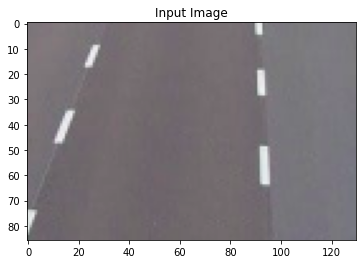

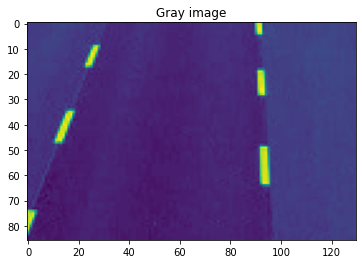

starting cordinates (0, 83) and ending cordinates (25, 9)
starting cordinates (92, 0) and ending cordinates (95, 64)
starting cordinates (1, 81) and ending cordinates (27, 9)
starting cordinates (90, 0) and ending cordinates (92, 63)


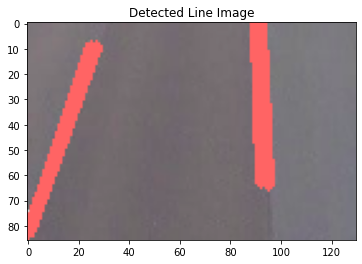

In [3]:
#Read image 
img = cv2.imread('line.png', cv2.IMREAD_COLOR)

# Visualize the input image
plt.imshow(img)
plt.title('Input Image')
plt.show()

#### YOUR CODE STARTS HERE #####
#convert the image to gray-scale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray)
plt.title('Gray image')
plt.show()
#### YOUR CODE ENDS HERE #####

#Find the edges in the image using canny detector

edges = cv2.Canny(gray, 50, 200)

#### YOUR CODE STARTS HERE #####

lines = cv2.HoughLinesP(edges, 1, np.pi/180, 15, minLineLength=60, maxLineGap=250)

for line in lines:
    x1, y1, x2, y2 = line[0]
    print(f"starting cordinates {(x1,y1)} and ending cordinates {(x2,y2)}")
    cv2.line(img, (x1, y1), (x2, y2), (255,100,100), 3)



#### YOUR CODE ENDS HERE #####
plt.imshow(img)
plt.title('Detected Line Image')
plt.show()

## Question 2: Point matching using RANSAC

Given two sets of points related by affine transformation(with an outlier rate), use the RANSAC method to estimate the Affine transformation parameters between them and the number of inliers(Matching points).

What is the estimated number of inliers for an outlier rate of 0.9?


In [4]:
import numpy as np
np.random.seed(0)


# Affine Transformation
# |x'|  = |a, b| * |x|  +  |tx|
# |y'|    |c, d|   |y|     |ty|
# points_t =    A   * points_s  + t

# -------------------------------------------------------------

class Transform():

    def create_case(self, out_rate):
        ''' CREATE_CASE

            Method to generate a test case for affine transformation

            Input arguments:
            - out_rate : the percentage of outliers in test case

            Outputs:
            - points_s : Source points that will be transformed
            - points_t : warped points
            - A, t : parameters of affine transformation, A is a 2x2
            matrix, t is a 2x1 vector, both of them are created randomly

        '''


        # Generate an affine transformation
        # A is a 2x2 matrix, with values in range -2 to 2
        A = 4 * np.random.rand(2, 2) - 2

        # t is a 2x1 vector, with values in range -10 to 10
        t = 20 * np.random.rand(2, 1) - 10
        
        # Set the num_points = 1000 for the test case
        num_points = 1000

        #### YOUR CODE STARTS HERE ####
        # Compute the no. of outliers and the no. of inliers respectively
        outliers = int(out_rate * num_points) 
        inliers =     int(num_points-(out_rate * num_points))
        #### YOUR CODE ENDS HERE ####
#         print(outliers,inliers)
        # Gernerate source points, with scope from (0,0) to (100, 100)
        points_s = 100 * np.random.rand(2, num_points)

        # Initialization of the warped points matrix
        points_t = np.zeros((2, num_points))

        #### YOUR CODE STARTS HERE ####
        # Compute inliers in warped points matrix by applying A and t

        points_t[:, :inliers] = np.matmul(A,points_s[:, :inliers]) + t
        #### YOUR CODE ENDS HERE ####

        # Outliers in warped points matrix
        points_t[:, inliers:] = 100 * np.random.rand(2, outliers)

        # Reset the order of warped points matrix
        # outliers and inliers will scatter randomly in test case
        rand_inx = np.random.permutation(num_points)
        points_s = points_s[:, rand_inx]
        points_t = points_t[:, rand_inx]

        return A, t, points_s, points_t

    def affine_transformation(self, points_s, points_t):  
        ''' AFFINE_TRANSFORMATION

            Perform affine transformation

            Input arguments:
            - points_t : points in target image
            - points_s : points in source image

            Outputs:

            - A, t : the affine transformation, A is a 2x2 matrix
            that indicates the rotation and scaling transformation,
            t is a 2x1 vector determines the translation

            Method:

            To estimate an affine transformation between two images,
            at least 3 corresponding points are needed.
            In this case, 6-parameter affine transformation are taken into
            consideration, which is shown as follows:

            | x' | = | a b | * | x | + | tx |
            | y' |   | c d |   | y |   | ty |

            For 3 corresponding points, 6 equations can be formed as below:

            | x1 y1 0  0  1 0 |       | a  |       | x1' |
            | 0  0  x1 y1 0 1 |       | b  |       | y1' |
            | x2 y2 0  0  1 0 |   *   | c  |   =   | x2' |
            | 0  0  x2 y2 0 1 |       | d  |       | y2' |
            | x3 y3 0  0  1 0 |       | tx |       | x3' |
            | 0  0  x3 y3 0 1 |       | ty |       | y3' |

            |------> M <------|   |-> theta <-|   |-> b <-|

            Solve the equation by calculating:  theta =  M/b
            Thus, affine transformation can be obtained as:

            A = | a b |     t = | tx |
                | c d |         | ty |

        '''

        #### YOUR CODE STARTS HERE ####
        M = np.zeros((6,6))
        M[0][0] = points_s[0][0]
        M[2][0] = points_s[0][1]
        M[4][0] = points_s[0][2]
        M[0][1] = points_s[1][0]
        M[2][1] = points_s[1][1]
        M[4][1] = points_s[1][2]
        
        M[1][2] = points_s[0][0]
        M[3][2] = points_s[0][1]
        M[5][2] = points_s[0][2]
        M[1][3] = points_s[1][0]
        M[3][3] = points_s[1][1]
        M[5][3] = points_s[1][2]
        
        M[1][5] = 1
        M[3][5] = 1
        M[5][5] = 1
        M[0][4] = 1
        M[2][4] = 1
        M[4][4] = 1
        
        b = np.zeros((6,1))
        b[0][0] = points_t[0][0]
        b[1][0] = points_t[1][0]
        b[2][0] = points_t[0][1]
        b[3][0] = points_t[1][1]
        b[4][0] = points_t[0][2]
        b[5][0] = points_t[1][2]
        
        
        M_inverse = np.linalg.pinv(M)
        
        theta = np.matmul(M_inverse, b) 
        
        
        A = np.zeros((2,2))
        t = np.zeros((2,1))
        
        A[0][0] = theta[0][0] 
        A[0][1] = theta[1][0] 
        A[1][0] = theta[2][0] 
        A[1][1] = theta[3][0] 
        t[0][0] = theta[4][0] 
        t[1][0] = theta[5][0]
        
#         print(M,b,theta,A,t)
        
        return A,t



        #### YOUR CODE ENDS HERE ####
# -------------------------------------------------------------

# Create instance
tf = Transform()

# Generate a test case as validation with
# a rate of outliers
out_rate = 0.90
A_true, t_true, points_s, points_t = tf.create_case(out_rate)
# At least 3 corresponding points to
# estimate affine transformation
L = 3
# Randomly select 3 pairs of points to do estimation
idx = np.random.randint(0, points_s.shape[1], (L, 1))


A_test, t_test = tf.affine_transformation(points_s[:, idx], points_t[:, idx])

# -------------------------------------------------------------
# Test Class RansacClass
# The number of iterations in RANSAC
ITER_NUM = 2000


class RansacClass():

    def __init__(self, L=3, thr=1): 
        ''' __INIT__

            Initialize the instance.

            Input arguments:

            - L : the number of corresponding points,
            default is 3
            - thr : threshold that determines which points are inliers
            by comparing residual with it

        '''

        self.L = L
        self.thr = thr

    def calculate_distance(self, A, t, points_s, points_t):     
        ''' CALCULATE_DISTANCE

            Compute residual length between estimation and 
            real target points.
 

            Input arguments:

            - A, t : the estimated affine transformation
                     (using least square)
            - points_s : key points taken from source image
            - points_t : key points taken from target image

            Output:

            - residual : Euclidean distance between target 
            points and estimated points. Euclidean distance is
            nothing but the residual length

        '''

        ###YOUR CODE START HERE

        points_t_estm = np.matmul(A,points_s) + t

        sqr = (np.square(points_t - points_t_estm)).sum(axis=0)
        residual = np.sqrt(sqr)

     
        return residual
        ###YOUR CODE ENDS HERE

    def apply_ransac(self, points_s, points_t):
        ''' APPLY_RANSAC

            Use this method to get the estimated affine 
            transformation, also inliers.

            Input arguments:

            - points_s : key points from source image
            - points_t : key points from target image

            Output:

            - A, t : estimated affine transformation
            - inliers : indices of inliers 

        '''
        #### YOUR CODE START HERE
        s = 0
        k = np.zeros((1,1000))
        
        for i in range(ITER_NUM):
            idx = np.random.randint(0, points_s.shape[1], (self.L, 1))
            A, t = tf.affine_transformation(points_s[:, idx], points_t[:, idx])
            residual = self.calculate_distance(A,t,points_s, points_t)

            inliers_count = (residual<(self.thr)).sum()

            if inliers_count > s:
                s = inliers_count
                Abest= A
                tbest = t
                k = np.where(residual<(self.thr))

            
        
        
        return Abest,tbest,k
        #### YOUR CODE ENDS HERE
# -------------------------------------------------------------

# Create instance
rs = RansacClass(L=3, thr=1)

residual = rs.calculate_distance(A_test, t_test, points_s, points_t)
A_rsc, t_rsc, inliers = rs.apply_ransac(points_s, points_t)

# print the number of inliners or point matches
print(inliers[0].shape)

(101,)


### Question 3: Detect corners in a given image using Harris Corner Detection Algorithm

Find the number of detected corner points in a given image (line.png) using Harris Corner Detection Algorithm. Note that, Following criterion MUST be satisfied while applying Harris Corner detection Algorithm:

(a)  The size of neighbourhood considered for corner detection = 2.
(b)  Aperture parameter of Sobel derivative used = 3.
(c)  Harris detector free parameter in the equation = 0.04.

How many corners are detected?



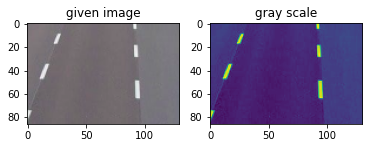

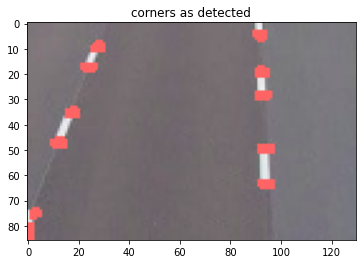

number of corners detected = 222


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

%matplotlib inline

# Read in the image
image = cv2.imread('line.png')
plt.subplot(1,2,1)
plt.imshow(image)
plt.title('given image')

# Make a copy of the image
image_copy = np.copy(image)

# Change color to RGB (from BGR)
image_copy = cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB)

###YOUR CODE STARTS HERE

## STEP 1:  Convert to grayscale 
gray = cv2.cvtColor(image_copy,cv2.COLOR_RGB2GRAY)
plt.subplot(1,2,2)
plt.imshow(gray)
plt.title('gray scale')
plt.show()
gray = np.float32(gray)

## STEP 2: Detect corners 
dst = cv2.cornerHarris(gray,2,3,0.04)

## STEP 3: Dilate corner image to enhance corner points
dst = cv2.dilate(dst,None)


## STEP 4:set threshold value as 0.1 * (maximum value of dilated corner image obtained from STEP3)
image[dst>0.01*dst.max()]=[255,100,100]

plt.imshow(image)
plt.title('corners as detected')
plt.show()

## STEP 5: Count numer of detected corner points and draw them on the image

print(f"number of corners detected = {(dst>(0.1*dst.max())).sum()}")



### YOUR CODE ENDS HERE

# Part-2

In this section, we will train a neural network to learn to identify numerals from [MNIST](http://yann.lecun.com/exdb/mnist/) dataset. Fill out the missing pieces in each of the following cells. 

In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torch.nn.functional as F
import timeit
import unittest

## Please DONOT remove these lines. 
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)

### Data Loading and Pre-processing

In [7]:
# check availability of GPU and set the device accordingly
#### YOUR CODE STARTS HERE ####
device = torch.device("cuda:0")

# define a transforms for preparing the dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.1307), std = (0.3081))])
         # convert the image to a pytorch tensor
        # normalise the images with mean (0.1307) and std (0.3081) of the dataset
#### YOUR CODE ENDS HERE ####

In [8]:
# Load the MNIST training, test datasets using `torchvision.datasets.MNIST` using the transform defined above
#### YOUR CODE STARTS HERE ####
train_dataset = datasets.MNIST("",train=True,download = True, transform = transform)
test_dataset =  datasets.MNIST("",train=False,download=True,transform=transform)
#### YOUR CODE ENDS HERE ####

In [9]:
# create dataloaders for training and test datasets
# use a batch size of 32 and set shuffle=True for the training set
#### YOUR CODE STARTS HERE ####
train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=32,shuffle=True) 
test_dataloader = torch.utils.data.DataLoader(test_dataset,batch_size=32,shuffle=False)
#### YOUR CODE ENDS HERE ####

### Network Definition

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #### YOUR CODE STARTS HERE ####
        self.activation = nn.ReLU()
        # define a conv layer with output channels as 16, kernel size of 3 and stride of 1
        self.conv1 = nn.Conv2d(in_channels = 1,out_channels = 16,kernel_size=3,stride = 1)
        
        # define a conv layer with output channels as 32, kernel size of 3 and stride of 1
        self.conv2 = nn.Conv2d(in_channels = 16,out_channels = 32,kernel_size=3,stride = 1)
        
        # define a conv layer with output channels as 64, kernel size of 3 and stride of 1
        self.conv3 = nn.Conv2d(in_channels = 32,out_channels = 64,kernel_size=3,stride = 1)
        
        # define a max pooling layer with kernel size 2
        self.m1 = nn.MaxPool2d(kernel_size=2,stride = 2)
        
        # define dropout layer with a probability of 0.25
        self.d1 = nn.Dropout2d(p=0.25)
        
        # define dropout layer with a probability of 0.5
        self.d2 = nn.Dropout2d(p=0.5)
        
        # define a linear(dense) layer with 128 output features
        self.fc1 = nn.Linear(in_features=64*11*11,out_features=128)
        
        # define a linear(dense) layer with output features corresponding to the number of classes in the dataset
        self.fc2 = nn.Linear(in_features=128,out_features=10)
        
        #### YOUR CODE ENDS HERE ####

    def forward(self, x):
        # Use the layers defined above in a sequential way (folow the same as the layer definitions above) and 
        # write the forward pass, after each of conv1, conv2, conv3 and fc1 use a relu activation. 
        # use the first dropout after maxpool and the other one before you final FC layer
        #### YOUR CODE STARTS HERE ####
        
        x = self.activation(self.conv1(x))
        x = self.activation(self.conv2(x))
        x = self.activation(self.conv3(x))
        x = self.m1(x)
        x = x.view(-1,64*11*11)
        x = self.d1(x)
        x = self.activation(self.fc1(x))
        x = self.d2(x)
        out = self.fc2(x)
        
        #### YOUR CODE ENDS HERE ####
        output = F.log_softmax(out, dim=1)
        return output

### Sanity Check
Make sure all the tests below pass without any errors, before you proceed with the training part.

In [11]:
import unittest

class TestImplementations(unittest.TestCase):
    
    # Dataloading tests
    def test_dataset(self):
        self.dataset_classes = ['0 - zero',
                                '1 - one',
                                '2 - two',
                                '3 - three',
                                '4 - four',
                                '5 - five',
                                '6 - six',
                                '7 - seven',
                                '8 - eight',
                                '9 - nine']
        self.assertTrue(train_dataset.classes == self.dataset_classes)
        self.assertTrue(train_dataset.train == True)
    
    def test_dataloader(self):        
        self.assertTrue(train_dataloader.batch_size == 32)
        self.assertTrue(test_dataloader.batch_size == 32)      
         
    def test_total_parameters(self):
        model = Net().to(device)
        self.assertTrue(sum(p.numel() for p in model.parameters()) == 1015946)

suite = unittest.TestLoader().loadTestsFromModule(TestImplementations())
unittest.TextTestRunner().run(suite)

...
----------------------------------------------------------------------
Ran 3 tests in 2.132s

OK


<unittest.runner.TextTestResult run=3 errors=0 failures=0>

### Training and Inference

In [12]:
import matplotlib.pyplot as plt
def visualize_loss_accuracy(loss,accuracy):
    plt.title("Loss vs Epochs", fontdict=None, loc='center')
    plt.xlabel("Epochs",fontdict=None)
    plt.ylabel("Loss",fontdict=None)
    plt.plot(loss)
    plt.grid()
    ymin, ymax = plt.ylim()
    plt.ylim(0, ymax)
    plt.show()

    plt.title("Accuracy vs Epochs", fontdict=None, loc='center')
    plt.xlabel("Epochs",fontdict=None)
    plt.ylabel("Accuracy",fontdict=None)
    plt.plot(accuracy)
    plt.grid()
    ymin, ymax = plt.ylim()
    plt.ylim(ymin, ymax)
    plt.show()

In [13]:
def train(model, device, train_loader, optimizer, epoch):
    train_loss = 0;correct =0;count = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        #### YOUR CODE STARTS HERE ####
        # send the image, target to the device
        data = data.to(device)
        target = target.to(device)
            
        # flush out the gradients stored in optimizer
        model.zero_grad()
            
        # pass the image to the model and assign the output to variable named output
        output = model(data)
        _, pred = torch.max(output.data, 1)
            
        # calculate the loss (use nll_loss in pytorch)
        loss = F.nll_loss(output, target)
        train_loss += loss.item()
        
        # do a backward pass
        loss.backward()
            
        # update the weights
        optimizer.step()
        
        count +=1
        correct += pred.eq(target.view_as(pred)).sum().item()
        #### YOUR CODE ENDS HERE ####
        
    
        if batch_idx % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
    train_loss /= count ;Accuracy = (100. * correct / len(train_loader.dataset))
    return train_loss,Accuracy
            

In [14]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
          ### YOUR CODE STARTS HERE ####
            # send the image, target to the device
            data = data.to(device)
            target = target.to(device)
            # pass the image to the model and assign the output to variable named output
            output = model(data)
            _, pred = torch.max(output.data, 1)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            
          #### YOUR CODE ENDS HERE ####
        
            # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

# Question 4

Use Adam as the optimiser and train the model for 25 epochs. Report the train, test loss and accuracies along with the total time taken for training. (Use plots if required)

In [15]:
%%time
model = Net().to(device)
optimizer = optim.Adam(model.parameters(),lr=0.001)
epochloss = []
epochAccuracy = []
epochs = 25
for epoch in range(1,epochs+1):
    loss,accuracy = train(model,device,train_dataloader,optimizer,epoch)
    epochloss.append(loss)
    epochAccuracy.append(accuracy)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.297180
Train Epoch: 1 [640/60000 (1%)]	Loss: 0.996239
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.114181
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.246074
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.472914
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.358214
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.322744
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.233767
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.157554
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.085345
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.579341
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.068230
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.061675
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.107572
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.066112
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.501029
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.352548
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.140978
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.384204
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.128786
Train Epoch: 1 [12800/60000 (

Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.007644
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.008731
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.250993
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.004047
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.153507
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.101410
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.014083
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.038801
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.034127
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.042720
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.034146
Train Epoch: 2 [53120/60000 (89%)]	Loss: 0.003980
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.003332
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.068302
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.006898
Train Epoch: 2 [55680/60000 (93%)]	Loss: 0.053542
Train Epoch: 2 [56320/60000 (94%)]	Loss: 0.187378
Train Epoch: 2 [56960/60000 (95%)]	Loss: 0.034380
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.008104
Train Epoch: 2 [58240/60000 (97%)]	Loss: 0.021638


Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.108686
Train Epoch: 4 [32640/60000 (54%)]	Loss: 0.010505
Train Epoch: 4 [33280/60000 (55%)]	Loss: 0.010048
Train Epoch: 4 [33920/60000 (57%)]	Loss: 0.057002
Train Epoch: 4 [34560/60000 (58%)]	Loss: 0.005134
Train Epoch: 4 [35200/60000 (59%)]	Loss: 0.032592
Train Epoch: 4 [35840/60000 (60%)]	Loss: 0.041143
Train Epoch: 4 [36480/60000 (61%)]	Loss: 0.300065
Train Epoch: 4 [37120/60000 (62%)]	Loss: 0.007852
Train Epoch: 4 [37760/60000 (63%)]	Loss: 0.058820
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.013339
Train Epoch: 4 [39040/60000 (65%)]	Loss: 0.021638
Train Epoch: 4 [39680/60000 (66%)]	Loss: 0.125523
Train Epoch: 4 [40320/60000 (67%)]	Loss: 0.006074
Train Epoch: 4 [40960/60000 (68%)]	Loss: 0.000081
Train Epoch: 4 [41600/60000 (69%)]	Loss: 0.010199
Train Epoch: 4 [42240/60000 (70%)]	Loss: 0.016902
Train Epoch: 4 [42880/60000 (71%)]	Loss: 0.010727
Train Epoch: 4 [43520/60000 (73%)]	Loss: 0.056391
Train Epoch: 4 [44160/60000 (74%)]	Loss: 0.133168


Train Epoch: 6 [17920/60000 (30%)]	Loss: 0.037097
Train Epoch: 6 [18560/60000 (31%)]	Loss: 0.070057
Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.046276
Train Epoch: 6 [19840/60000 (33%)]	Loss: 0.013311
Train Epoch: 6 [20480/60000 (34%)]	Loss: 0.010368
Train Epoch: 6 [21120/60000 (35%)]	Loss: 0.021883
Train Epoch: 6 [21760/60000 (36%)]	Loss: 0.054773
Train Epoch: 6 [22400/60000 (37%)]	Loss: 0.148804
Train Epoch: 6 [23040/60000 (38%)]	Loss: 0.024998
Train Epoch: 6 [23680/60000 (39%)]	Loss: 0.002847
Train Epoch: 6 [24320/60000 (41%)]	Loss: 0.003280
Train Epoch: 6 [24960/60000 (42%)]	Loss: 0.004052
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.031010
Train Epoch: 6 [26240/60000 (44%)]	Loss: 0.002824
Train Epoch: 6 [26880/60000 (45%)]	Loss: 0.006198
Train Epoch: 6 [27520/60000 (46%)]	Loss: 0.014728
Train Epoch: 6 [28160/60000 (47%)]	Loss: 0.047124
Train Epoch: 6 [28800/60000 (48%)]	Loss: 0.169668
Train Epoch: 6 [29440/60000 (49%)]	Loss: 0.013758
Train Epoch: 6 [30080/60000 (50%)]	Loss: 0.002663


Train Epoch: 8 [3200/60000 (5%)]	Loss: 0.087078
Train Epoch: 8 [3840/60000 (6%)]	Loss: 0.371223
Train Epoch: 8 [4480/60000 (7%)]	Loss: 0.005066
Train Epoch: 8 [5120/60000 (9%)]	Loss: 0.026675
Train Epoch: 8 [5760/60000 (10%)]	Loss: 0.064049
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.009997
Train Epoch: 8 [7040/60000 (12%)]	Loss: 0.002744
Train Epoch: 8 [7680/60000 (13%)]	Loss: 0.001772
Train Epoch: 8 [8320/60000 (14%)]	Loss: 0.008369
Train Epoch: 8 [8960/60000 (15%)]	Loss: 0.005626
Train Epoch: 8 [9600/60000 (16%)]	Loss: 0.044054
Train Epoch: 8 [10240/60000 (17%)]	Loss: 0.003990
Train Epoch: 8 [10880/60000 (18%)]	Loss: 0.000956
Train Epoch: 8 [11520/60000 (19%)]	Loss: 0.001064
Train Epoch: 8 [12160/60000 (20%)]	Loss: 0.024696
Train Epoch: 8 [12800/60000 (21%)]	Loss: 0.017031
Train Epoch: 8 [13440/60000 (22%)]	Loss: 0.134409
Train Epoch: 8 [14080/60000 (23%)]	Loss: 0.402088
Train Epoch: 8 [14720/60000 (25%)]	Loss: 0.003974
Train Epoch: 8 [15360/60000 (26%)]	Loss: 0.070612
Train Epoch: 8 

Train Epoch: 9 [48640/60000 (81%)]	Loss: 0.001565
Train Epoch: 9 [49280/60000 (82%)]	Loss: 0.013437
Train Epoch: 9 [49920/60000 (83%)]	Loss: 0.000454
Train Epoch: 9 [50560/60000 (84%)]	Loss: 0.009466
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.000034
Train Epoch: 9 [51840/60000 (86%)]	Loss: 0.067716
Train Epoch: 9 [52480/60000 (87%)]	Loss: 0.006021
Train Epoch: 9 [53120/60000 (89%)]	Loss: 0.004298
Train Epoch: 9 [53760/60000 (90%)]	Loss: 0.031135
Train Epoch: 9 [54400/60000 (91%)]	Loss: 0.001495
Train Epoch: 9 [55040/60000 (92%)]	Loss: 0.015024
Train Epoch: 9 [55680/60000 (93%)]	Loss: 0.045060
Train Epoch: 9 [56320/60000 (94%)]	Loss: 0.010393
Train Epoch: 9 [56960/60000 (95%)]	Loss: 0.003655
Train Epoch: 9 [57600/60000 (96%)]	Loss: 0.002135
Train Epoch: 9 [58240/60000 (97%)]	Loss: 0.000451
Train Epoch: 9 [58880/60000 (98%)]	Loss: 0.002611
Train Epoch: 9 [59520/60000 (99%)]	Loss: 0.002311
Train Epoch: 10 [0/60000 (0%)]	Loss: 0.001083
Train Epoch: 10 [640/60000 (1%)]	Loss: 0.002518
Train 

Train Epoch: 11 [32640/60000 (54%)]	Loss: 0.001784
Train Epoch: 11 [33280/60000 (55%)]	Loss: 0.000304
Train Epoch: 11 [33920/60000 (57%)]	Loss: 0.007684
Train Epoch: 11 [34560/60000 (58%)]	Loss: 0.188935
Train Epoch: 11 [35200/60000 (59%)]	Loss: 0.025891
Train Epoch: 11 [35840/60000 (60%)]	Loss: 0.030234
Train Epoch: 11 [36480/60000 (61%)]	Loss: 0.007763
Train Epoch: 11 [37120/60000 (62%)]	Loss: 0.031894
Train Epoch: 11 [37760/60000 (63%)]	Loss: 0.000140
Train Epoch: 11 [38400/60000 (64%)]	Loss: 0.048897
Train Epoch: 11 [39040/60000 (65%)]	Loss: 0.000765
Train Epoch: 11 [39680/60000 (66%)]	Loss: 0.027699
Train Epoch: 11 [40320/60000 (67%)]	Loss: 0.005718
Train Epoch: 11 [40960/60000 (68%)]	Loss: 0.000649
Train Epoch: 11 [41600/60000 (69%)]	Loss: 0.000585
Train Epoch: 11 [42240/60000 (70%)]	Loss: 0.003888
Train Epoch: 11 [42880/60000 (71%)]	Loss: 0.000017
Train Epoch: 11 [43520/60000 (73%)]	Loss: 0.132610
Train Epoch: 11 [44160/60000 (74%)]	Loss: 0.004132
Train Epoch: 11 [44800/60000 (7

Train Epoch: 13 [16000/60000 (27%)]	Loss: 0.000182
Train Epoch: 13 [16640/60000 (28%)]	Loss: 0.059648
Train Epoch: 13 [17280/60000 (29%)]	Loss: 0.000607
Train Epoch: 13 [17920/60000 (30%)]	Loss: 0.000646
Train Epoch: 13 [18560/60000 (31%)]	Loss: 0.024452
Train Epoch: 13 [19200/60000 (32%)]	Loss: 0.077050
Train Epoch: 13 [19840/60000 (33%)]	Loss: 0.016444
Train Epoch: 13 [20480/60000 (34%)]	Loss: 0.000478
Train Epoch: 13 [21120/60000 (35%)]	Loss: 0.000620
Train Epoch: 13 [21760/60000 (36%)]	Loss: 0.001206
Train Epoch: 13 [22400/60000 (37%)]	Loss: 0.107551
Train Epoch: 13 [23040/60000 (38%)]	Loss: 0.000084
Train Epoch: 13 [23680/60000 (39%)]	Loss: 0.005663
Train Epoch: 13 [24320/60000 (41%)]	Loss: 0.000047
Train Epoch: 13 [24960/60000 (42%)]	Loss: 0.000217
Train Epoch: 13 [25600/60000 (43%)]	Loss: 0.052586
Train Epoch: 13 [26240/60000 (44%)]	Loss: 0.001661
Train Epoch: 13 [26880/60000 (45%)]	Loss: 0.000508
Train Epoch: 13 [27520/60000 (46%)]	Loss: 0.044511
Train Epoch: 13 [28160/60000 (4

Train Epoch: 14 [59520/60000 (99%)]	Loss: 0.169069
Train Epoch: 15 [0/60000 (0%)]	Loss: 0.001588
Train Epoch: 15 [640/60000 (1%)]	Loss: 0.010699
Train Epoch: 15 [1280/60000 (2%)]	Loss: 0.038563
Train Epoch: 15 [1920/60000 (3%)]	Loss: 0.000012
Train Epoch: 15 [2560/60000 (4%)]	Loss: 0.003943
Train Epoch: 15 [3200/60000 (5%)]	Loss: 0.001778
Train Epoch: 15 [3840/60000 (6%)]	Loss: 0.015623
Train Epoch: 15 [4480/60000 (7%)]	Loss: 0.002881
Train Epoch: 15 [5120/60000 (9%)]	Loss: 0.000599
Train Epoch: 15 [5760/60000 (10%)]	Loss: 0.006671
Train Epoch: 15 [6400/60000 (11%)]	Loss: 0.000115
Train Epoch: 15 [7040/60000 (12%)]	Loss: 0.000113
Train Epoch: 15 [7680/60000 (13%)]	Loss: 0.000130
Train Epoch: 15 [8320/60000 (14%)]	Loss: 0.005913
Train Epoch: 15 [8960/60000 (15%)]	Loss: 0.000079
Train Epoch: 15 [9600/60000 (16%)]	Loss: 0.002421
Train Epoch: 15 [10240/60000 (17%)]	Loss: 0.000138
Train Epoch: 15 [10880/60000 (18%)]	Loss: 0.000172
Train Epoch: 15 [11520/60000 (19%)]	Loss: 0.012706
Train Epo

Train Epoch: 16 [42880/60000 (71%)]	Loss: 0.083399
Train Epoch: 16 [43520/60000 (73%)]	Loss: 0.001305
Train Epoch: 16 [44160/60000 (74%)]	Loss: 0.000555
Train Epoch: 16 [44800/60000 (75%)]	Loss: 0.000350
Train Epoch: 16 [45440/60000 (76%)]	Loss: 0.000108
Train Epoch: 16 [46080/60000 (77%)]	Loss: 0.212873
Train Epoch: 16 [46720/60000 (78%)]	Loss: 0.011000
Train Epoch: 16 [47360/60000 (79%)]	Loss: 0.008527
Train Epoch: 16 [48000/60000 (80%)]	Loss: 0.000020
Train Epoch: 16 [48640/60000 (81%)]	Loss: 0.003450
Train Epoch: 16 [49280/60000 (82%)]	Loss: 0.003996
Train Epoch: 16 [49920/60000 (83%)]	Loss: 0.011929
Train Epoch: 16 [50560/60000 (84%)]	Loss: 0.011503
Train Epoch: 16 [51200/60000 (85%)]	Loss: 0.022655
Train Epoch: 16 [51840/60000 (86%)]	Loss: 0.145607
Train Epoch: 16 [52480/60000 (87%)]	Loss: 0.000805
Train Epoch: 16 [53120/60000 (89%)]	Loss: 0.000149
Train Epoch: 16 [53760/60000 (90%)]	Loss: 0.000719
Train Epoch: 16 [54400/60000 (91%)]	Loss: 0.079606
Train Epoch: 16 [55040/60000 (9

Train Epoch: 18 [26240/60000 (44%)]	Loss: 0.005588
Train Epoch: 18 [26880/60000 (45%)]	Loss: 0.052274
Train Epoch: 18 [27520/60000 (46%)]	Loss: 0.001781
Train Epoch: 18 [28160/60000 (47%)]	Loss: 0.000739
Train Epoch: 18 [28800/60000 (48%)]	Loss: 0.003349
Train Epoch: 18 [29440/60000 (49%)]	Loss: 0.001260
Train Epoch: 18 [30080/60000 (50%)]	Loss: 0.057699
Train Epoch: 18 [30720/60000 (51%)]	Loss: 0.000161
Train Epoch: 18 [31360/60000 (52%)]	Loss: 0.148852
Train Epoch: 18 [32000/60000 (53%)]	Loss: 0.087704
Train Epoch: 18 [32640/60000 (54%)]	Loss: 0.000091
Train Epoch: 18 [33280/60000 (55%)]	Loss: 0.000532
Train Epoch: 18 [33920/60000 (57%)]	Loss: 0.000036
Train Epoch: 18 [34560/60000 (58%)]	Loss: 0.000123
Train Epoch: 18 [35200/60000 (59%)]	Loss: 0.017165
Train Epoch: 18 [35840/60000 (60%)]	Loss: 0.000302
Train Epoch: 18 [36480/60000 (61%)]	Loss: 0.000476
Train Epoch: 18 [37120/60000 (62%)]	Loss: 0.000879
Train Epoch: 18 [37760/60000 (63%)]	Loss: 0.002432
Train Epoch: 18 [38400/60000 (6

Train Epoch: 20 [9600/60000 (16%)]	Loss: 0.226018
Train Epoch: 20 [10240/60000 (17%)]	Loss: 0.000404
Train Epoch: 20 [10880/60000 (18%)]	Loss: 0.001018
Train Epoch: 20 [11520/60000 (19%)]	Loss: 0.003831
Train Epoch: 20 [12160/60000 (20%)]	Loss: 0.000238
Train Epoch: 20 [12800/60000 (21%)]	Loss: 0.009512
Train Epoch: 20 [13440/60000 (22%)]	Loss: 0.000908
Train Epoch: 20 [14080/60000 (23%)]	Loss: 0.000147
Train Epoch: 20 [14720/60000 (25%)]	Loss: 0.000007
Train Epoch: 20 [15360/60000 (26%)]	Loss: 0.000056
Train Epoch: 20 [16000/60000 (27%)]	Loss: 0.000312
Train Epoch: 20 [16640/60000 (28%)]	Loss: 0.019838
Train Epoch: 20 [17280/60000 (29%)]	Loss: 0.000020
Train Epoch: 20 [17920/60000 (30%)]	Loss: 0.008404
Train Epoch: 20 [18560/60000 (31%)]	Loss: 0.000988
Train Epoch: 20 [19200/60000 (32%)]	Loss: 0.006939
Train Epoch: 20 [19840/60000 (33%)]	Loss: 0.002265
Train Epoch: 20 [20480/60000 (34%)]	Loss: 0.001902
Train Epoch: 20 [21120/60000 (35%)]	Loss: 0.018124
Train Epoch: 20 [21760/60000 (36

Train Epoch: 21 [53120/60000 (89%)]	Loss: 0.004693
Train Epoch: 21 [53760/60000 (90%)]	Loss: 0.000489
Train Epoch: 21 [54400/60000 (91%)]	Loss: 0.000127
Train Epoch: 21 [55040/60000 (92%)]	Loss: 0.013936
Train Epoch: 21 [55680/60000 (93%)]	Loss: 0.000442
Train Epoch: 21 [56320/60000 (94%)]	Loss: 0.000050
Train Epoch: 21 [56960/60000 (95%)]	Loss: 0.000203
Train Epoch: 21 [57600/60000 (96%)]	Loss: 0.000950
Train Epoch: 21 [58240/60000 (97%)]	Loss: 0.000236
Train Epoch: 21 [58880/60000 (98%)]	Loss: 0.000023
Train Epoch: 21 [59520/60000 (99%)]	Loss: 0.003348
Train Epoch: 22 [0/60000 (0%)]	Loss: 0.076344
Train Epoch: 22 [640/60000 (1%)]	Loss: 0.000373
Train Epoch: 22 [1280/60000 (2%)]	Loss: 0.001121
Train Epoch: 22 [1920/60000 (3%)]	Loss: 0.000023
Train Epoch: 22 [2560/60000 (4%)]	Loss: 0.000216
Train Epoch: 22 [3200/60000 (5%)]	Loss: 0.002321
Train Epoch: 22 [3840/60000 (6%)]	Loss: 0.000001
Train Epoch: 22 [4480/60000 (7%)]	Loss: 0.008060
Train Epoch: 22 [5120/60000 (9%)]	Loss: 0.068242
Tr

Train Epoch: 23 [36480/60000 (61%)]	Loss: 0.003659
Train Epoch: 23 [37120/60000 (62%)]	Loss: 0.000083
Train Epoch: 23 [37760/60000 (63%)]	Loss: 0.000094
Train Epoch: 23 [38400/60000 (64%)]	Loss: 0.040461
Train Epoch: 23 [39040/60000 (65%)]	Loss: 0.002646
Train Epoch: 23 [39680/60000 (66%)]	Loss: 0.067240
Train Epoch: 23 [40320/60000 (67%)]	Loss: 0.000790
Train Epoch: 23 [40960/60000 (68%)]	Loss: 0.000178
Train Epoch: 23 [41600/60000 (69%)]	Loss: 0.001468
Train Epoch: 23 [42240/60000 (70%)]	Loss: 0.000673
Train Epoch: 23 [42880/60000 (71%)]	Loss: 0.001832
Train Epoch: 23 [43520/60000 (73%)]	Loss: 0.001381
Train Epoch: 23 [44160/60000 (74%)]	Loss: 0.001697
Train Epoch: 23 [44800/60000 (75%)]	Loss: 0.008903
Train Epoch: 23 [45440/60000 (76%)]	Loss: 0.001861
Train Epoch: 23 [46080/60000 (77%)]	Loss: 0.000010
Train Epoch: 23 [46720/60000 (78%)]	Loss: 0.002308
Train Epoch: 23 [47360/60000 (79%)]	Loss: 0.000778
Train Epoch: 23 [48000/60000 (80%)]	Loss: 0.015698
Train Epoch: 23 [48640/60000 (8

Train Epoch: 25 [19840/60000 (33%)]	Loss: 0.000376
Train Epoch: 25 [20480/60000 (34%)]	Loss: 0.038308
Train Epoch: 25 [21120/60000 (35%)]	Loss: 0.042037
Train Epoch: 25 [21760/60000 (36%)]	Loss: 0.002601
Train Epoch: 25 [22400/60000 (37%)]	Loss: 0.000321
Train Epoch: 25 [23040/60000 (38%)]	Loss: 0.020869
Train Epoch: 25 [23680/60000 (39%)]	Loss: 0.066350
Train Epoch: 25 [24320/60000 (41%)]	Loss: 0.000413
Train Epoch: 25 [24960/60000 (42%)]	Loss: 0.000008
Train Epoch: 25 [25600/60000 (43%)]	Loss: 0.000156
Train Epoch: 25 [26240/60000 (44%)]	Loss: 0.003550
Train Epoch: 25 [26880/60000 (45%)]	Loss: 0.000021
Train Epoch: 25 [27520/60000 (46%)]	Loss: 0.000019
Train Epoch: 25 [28160/60000 (47%)]	Loss: 0.000166
Train Epoch: 25 [28800/60000 (48%)]	Loss: 0.000852
Train Epoch: 25 [29440/60000 (49%)]	Loss: 0.125959
Train Epoch: 25 [30080/60000 (50%)]	Loss: 0.010376
Train Epoch: 25 [30720/60000 (51%)]	Loss: 0.000582
Train Epoch: 25 [31360/60000 (52%)]	Loss: 0.000008
Train Epoch: 25 [32000/60000 (5

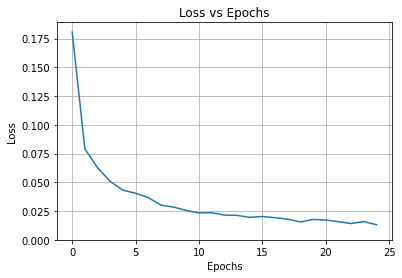

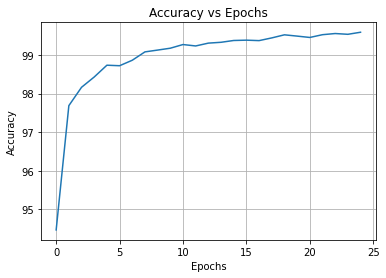

In [16]:
visualize_loss_accuracy(epochloss,epochAccuracy)

Above is the training loss and accuracy

In [17]:
test(model,device,test_dataloader)


Test set: Average loss: 0.0268, Accuracy: 9938/10000 (99%)



# Question 5

Modify the network defined in the previous step to replace ReLU activations with Sigmoid and report the final test accuracy. Is there a drop in accuracy, what do you think is the reason? 

replace_relu_to_sigmoid() is the function defined to convert activation function from ReLU to Sigmoid.

In [18]:
def replace_relu_to_sigmoid(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.ReLU):
            setattr(model, child_name, nn.Sigmoid())
        else:
            replace_relu_to_sigmoid(child)

we create an object model_sigmoid1() using the template defined in Net() class and apply replace_relu_to_sigmoid() function to our object model.

In [19]:
model_sigmoid1 = Net().to(device)          
model_sigmoid1.apply(replace_relu_to_sigmoid)
model_sigmoid1

Net(
  (activation): Sigmoid()
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (m1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (d1): Dropout2d(p=0.25, inplace=False)
  (d2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=7744, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

###### we see that the activation function is changed from ReLU to Sigmoid 

In [20]:
%%time
optimizer = optim.Adam(model_sigmoid1.parameters(),lr=0.001)
epochloss = []
epochAccuracy = []
epochs = 25
for epoch in range(1,epochs+1):
    loss,accuracy = train(model_sigmoid1,device,train_dataloader,optimizer,epoch)
    epochloss.append(loss)
    epochAccuracy.append(accuracy)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.353177
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.394239
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.336874
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.311644
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.434558
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.331872
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.325353
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.303941
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.318463
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.299011
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.262952
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.336854
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.255948
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.307074
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.268199
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.313499
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.289489
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.293325
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.317029
Train Epoch: 1 [12160/60000 (20%)]	Loss: 2.274210
Train Epoch: 1 [12800/60000 (

Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.142579
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.050421
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.143555
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.348548
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.035747
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.072963
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.207897
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.079719
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.185837
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.194362
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.224531
Train Epoch: 2 [53120/60000 (89%)]	Loss: 0.249992
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.053484
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.298653
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.394565
Train Epoch: 2 [55680/60000 (93%)]	Loss: 0.192371
Train Epoch: 2 [56320/60000 (94%)]	Loss: 0.064034
Train Epoch: 2 [56960/60000 (95%)]	Loss: 0.077995
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.046328
Train Epoch: 2 [58240/60000 (97%)]	Loss: 0.109958


Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.097645
Train Epoch: 4 [32640/60000 (54%)]	Loss: 0.024999
Train Epoch: 4 [33280/60000 (55%)]	Loss: 0.015302
Train Epoch: 4 [33920/60000 (57%)]	Loss: 0.017119
Train Epoch: 4 [34560/60000 (58%)]	Loss: 0.170444
Train Epoch: 4 [35200/60000 (59%)]	Loss: 0.226979
Train Epoch: 4 [35840/60000 (60%)]	Loss: 0.155758
Train Epoch: 4 [36480/60000 (61%)]	Loss: 0.195916
Train Epoch: 4 [37120/60000 (62%)]	Loss: 0.036804
Train Epoch: 4 [37760/60000 (63%)]	Loss: 0.319311
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.164514
Train Epoch: 4 [39040/60000 (65%)]	Loss: 0.185606
Train Epoch: 4 [39680/60000 (66%)]	Loss: 0.038684
Train Epoch: 4 [40320/60000 (67%)]	Loss: 0.116658
Train Epoch: 4 [40960/60000 (68%)]	Loss: 0.018069
Train Epoch: 4 [41600/60000 (69%)]	Loss: 0.036768
Train Epoch: 4 [42240/60000 (70%)]	Loss: 0.091939
Train Epoch: 4 [42880/60000 (71%)]	Loss: 0.103713
Train Epoch: 4 [43520/60000 (73%)]	Loss: 0.028772
Train Epoch: 4 [44160/60000 (74%)]	Loss: 0.014619


Train Epoch: 6 [17920/60000 (30%)]	Loss: 0.044110
Train Epoch: 6 [18560/60000 (31%)]	Loss: 0.003112
Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.057623
Train Epoch: 6 [19840/60000 (33%)]	Loss: 0.113928
Train Epoch: 6 [20480/60000 (34%)]	Loss: 0.046566
Train Epoch: 6 [21120/60000 (35%)]	Loss: 0.080404
Train Epoch: 6 [21760/60000 (36%)]	Loss: 0.014604
Train Epoch: 6 [22400/60000 (37%)]	Loss: 0.034898
Train Epoch: 6 [23040/60000 (38%)]	Loss: 0.045311
Train Epoch: 6 [23680/60000 (39%)]	Loss: 0.065624
Train Epoch: 6 [24320/60000 (41%)]	Loss: 0.025984
Train Epoch: 6 [24960/60000 (42%)]	Loss: 0.023336
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.003050
Train Epoch: 6 [26240/60000 (44%)]	Loss: 0.002626
Train Epoch: 6 [26880/60000 (45%)]	Loss: 0.004168
Train Epoch: 6 [27520/60000 (46%)]	Loss: 0.023587
Train Epoch: 6 [28160/60000 (47%)]	Loss: 0.109595
Train Epoch: 6 [28800/60000 (48%)]	Loss: 0.055464
Train Epoch: 6 [29440/60000 (49%)]	Loss: 0.001239
Train Epoch: 6 [30080/60000 (50%)]	Loss: 0.049856


Train Epoch: 8 [3200/60000 (5%)]	Loss: 0.014413
Train Epoch: 8 [3840/60000 (6%)]	Loss: 0.025902
Train Epoch: 8 [4480/60000 (7%)]	Loss: 0.020630
Train Epoch: 8 [5120/60000 (9%)]	Loss: 0.018204
Train Epoch: 8 [5760/60000 (10%)]	Loss: 0.099762
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.045542
Train Epoch: 8 [7040/60000 (12%)]	Loss: 0.281633
Train Epoch: 8 [7680/60000 (13%)]	Loss: 0.198429
Train Epoch: 8 [8320/60000 (14%)]	Loss: 0.243423
Train Epoch: 8 [8960/60000 (15%)]	Loss: 0.009106
Train Epoch: 8 [9600/60000 (16%)]	Loss: 0.054665
Train Epoch: 8 [10240/60000 (17%)]	Loss: 0.016342
Train Epoch: 8 [10880/60000 (18%)]	Loss: 0.005332
Train Epoch: 8 [11520/60000 (19%)]	Loss: 0.025513
Train Epoch: 8 [12160/60000 (20%)]	Loss: 0.014622
Train Epoch: 8 [12800/60000 (21%)]	Loss: 0.030998
Train Epoch: 8 [13440/60000 (22%)]	Loss: 0.005390
Train Epoch: 8 [14080/60000 (23%)]	Loss: 0.022907
Train Epoch: 8 [14720/60000 (25%)]	Loss: 0.006399
Train Epoch: 8 [15360/60000 (26%)]	Loss: 0.001261
Train Epoch: 8 

Train Epoch: 9 [48640/60000 (81%)]	Loss: 0.030683
Train Epoch: 9 [49280/60000 (82%)]	Loss: 0.004888
Train Epoch: 9 [49920/60000 (83%)]	Loss: 0.013641
Train Epoch: 9 [50560/60000 (84%)]	Loss: 0.043158
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.001780
Train Epoch: 9 [51840/60000 (86%)]	Loss: 0.008163
Train Epoch: 9 [52480/60000 (87%)]	Loss: 0.129798
Train Epoch: 9 [53120/60000 (89%)]	Loss: 0.025640
Train Epoch: 9 [53760/60000 (90%)]	Loss: 0.001338
Train Epoch: 9 [54400/60000 (91%)]	Loss: 0.135111
Train Epoch: 9 [55040/60000 (92%)]	Loss: 0.093044
Train Epoch: 9 [55680/60000 (93%)]	Loss: 0.076425
Train Epoch: 9 [56320/60000 (94%)]	Loss: 0.037554
Train Epoch: 9 [56960/60000 (95%)]	Loss: 0.061659
Train Epoch: 9 [57600/60000 (96%)]	Loss: 0.003572
Train Epoch: 9 [58240/60000 (97%)]	Loss: 0.076801
Train Epoch: 9 [58880/60000 (98%)]	Loss: 0.002189
Train Epoch: 9 [59520/60000 (99%)]	Loss: 0.052510
Train Epoch: 10 [0/60000 (0%)]	Loss: 0.006251
Train Epoch: 10 [640/60000 (1%)]	Loss: 0.018169
Train 

Train Epoch: 11 [32640/60000 (54%)]	Loss: 0.009903
Train Epoch: 11 [33280/60000 (55%)]	Loss: 0.141063
Train Epoch: 11 [33920/60000 (57%)]	Loss: 0.005124
Train Epoch: 11 [34560/60000 (58%)]	Loss: 0.009526
Train Epoch: 11 [35200/60000 (59%)]	Loss: 0.007424
Train Epoch: 11 [35840/60000 (60%)]	Loss: 0.002088
Train Epoch: 11 [36480/60000 (61%)]	Loss: 0.010187
Train Epoch: 11 [37120/60000 (62%)]	Loss: 0.016475
Train Epoch: 11 [37760/60000 (63%)]	Loss: 0.024477
Train Epoch: 11 [38400/60000 (64%)]	Loss: 0.042782
Train Epoch: 11 [39040/60000 (65%)]	Loss: 0.038709
Train Epoch: 11 [39680/60000 (66%)]	Loss: 0.001909
Train Epoch: 11 [40320/60000 (67%)]	Loss: 0.071473
Train Epoch: 11 [40960/60000 (68%)]	Loss: 0.000594
Train Epoch: 11 [41600/60000 (69%)]	Loss: 0.003147
Train Epoch: 11 [42240/60000 (70%)]	Loss: 0.067339
Train Epoch: 11 [42880/60000 (71%)]	Loss: 0.027072
Train Epoch: 11 [43520/60000 (73%)]	Loss: 0.026827
Train Epoch: 11 [44160/60000 (74%)]	Loss: 0.005961
Train Epoch: 11 [44800/60000 (7

Train Epoch: 13 [16000/60000 (27%)]	Loss: 0.002144
Train Epoch: 13 [16640/60000 (28%)]	Loss: 0.002812
Train Epoch: 13 [17280/60000 (29%)]	Loss: 0.002314
Train Epoch: 13 [17920/60000 (30%)]	Loss: 0.001583
Train Epoch: 13 [18560/60000 (31%)]	Loss: 0.151734
Train Epoch: 13 [19200/60000 (32%)]	Loss: 0.097812
Train Epoch: 13 [19840/60000 (33%)]	Loss: 0.030821
Train Epoch: 13 [20480/60000 (34%)]	Loss: 0.002562
Train Epoch: 13 [21120/60000 (35%)]	Loss: 0.006135
Train Epoch: 13 [21760/60000 (36%)]	Loss: 0.002637
Train Epoch: 13 [22400/60000 (37%)]	Loss: 0.015865
Train Epoch: 13 [23040/60000 (38%)]	Loss: 0.098120
Train Epoch: 13 [23680/60000 (39%)]	Loss: 0.000893
Train Epoch: 13 [24320/60000 (41%)]	Loss: 0.007336
Train Epoch: 13 [24960/60000 (42%)]	Loss: 0.001143
Train Epoch: 13 [25600/60000 (43%)]	Loss: 0.000714
Train Epoch: 13 [26240/60000 (44%)]	Loss: 0.008555
Train Epoch: 13 [26880/60000 (45%)]	Loss: 0.002623
Train Epoch: 13 [27520/60000 (46%)]	Loss: 0.024485
Train Epoch: 13 [28160/60000 (4

Train Epoch: 14 [59520/60000 (99%)]	Loss: 0.012885
Train Epoch: 15 [0/60000 (0%)]	Loss: 0.030484
Train Epoch: 15 [640/60000 (1%)]	Loss: 0.000746
Train Epoch: 15 [1280/60000 (2%)]	Loss: 0.010351
Train Epoch: 15 [1920/60000 (3%)]	Loss: 0.000644
Train Epoch: 15 [2560/60000 (4%)]	Loss: 0.012718
Train Epoch: 15 [3200/60000 (5%)]	Loss: 0.191027
Train Epoch: 15 [3840/60000 (6%)]	Loss: 0.018612
Train Epoch: 15 [4480/60000 (7%)]	Loss: 0.016568
Train Epoch: 15 [5120/60000 (9%)]	Loss: 0.173640
Train Epoch: 15 [5760/60000 (10%)]	Loss: 0.016059
Train Epoch: 15 [6400/60000 (11%)]	Loss: 0.011383
Train Epoch: 15 [7040/60000 (12%)]	Loss: 0.022343
Train Epoch: 15 [7680/60000 (13%)]	Loss: 0.032648
Train Epoch: 15 [8320/60000 (14%)]	Loss: 0.015907
Train Epoch: 15 [8960/60000 (15%)]	Loss: 0.012182
Train Epoch: 15 [9600/60000 (16%)]	Loss: 0.011239
Train Epoch: 15 [10240/60000 (17%)]	Loss: 0.008031
Train Epoch: 15 [10880/60000 (18%)]	Loss: 0.005995
Train Epoch: 15 [11520/60000 (19%)]	Loss: 0.005731
Train Epo

Train Epoch: 16 [42880/60000 (71%)]	Loss: 0.000805
Train Epoch: 16 [43520/60000 (73%)]	Loss: 0.021147
Train Epoch: 16 [44160/60000 (74%)]	Loss: 0.000256
Train Epoch: 16 [44800/60000 (75%)]	Loss: 0.003944
Train Epoch: 16 [45440/60000 (76%)]	Loss: 0.010439
Train Epoch: 16 [46080/60000 (77%)]	Loss: 0.001442
Train Epoch: 16 [46720/60000 (78%)]	Loss: 0.001581
Train Epoch: 16 [47360/60000 (79%)]	Loss: 0.001322
Train Epoch: 16 [48000/60000 (80%)]	Loss: 0.018564
Train Epoch: 16 [48640/60000 (81%)]	Loss: 0.001997
Train Epoch: 16 [49280/60000 (82%)]	Loss: 0.063159
Train Epoch: 16 [49920/60000 (83%)]	Loss: 0.005442
Train Epoch: 16 [50560/60000 (84%)]	Loss: 0.003236
Train Epoch: 16 [51200/60000 (85%)]	Loss: 0.003139
Train Epoch: 16 [51840/60000 (86%)]	Loss: 0.001646
Train Epoch: 16 [52480/60000 (87%)]	Loss: 0.023080
Train Epoch: 16 [53120/60000 (89%)]	Loss: 0.000921
Train Epoch: 16 [53760/60000 (90%)]	Loss: 0.001440
Train Epoch: 16 [54400/60000 (91%)]	Loss: 0.000880
Train Epoch: 16 [55040/60000 (9

Train Epoch: 18 [26240/60000 (44%)]	Loss: 0.001107
Train Epoch: 18 [26880/60000 (45%)]	Loss: 0.099197
Train Epoch: 18 [27520/60000 (46%)]	Loss: 0.003158
Train Epoch: 18 [28160/60000 (47%)]	Loss: 0.001477
Train Epoch: 18 [28800/60000 (48%)]	Loss: 0.000522
Train Epoch: 18 [29440/60000 (49%)]	Loss: 0.239230
Train Epoch: 18 [30080/60000 (50%)]	Loss: 0.005313
Train Epoch: 18 [30720/60000 (51%)]	Loss: 0.001628
Train Epoch: 18 [31360/60000 (52%)]	Loss: 0.006263
Train Epoch: 18 [32000/60000 (53%)]	Loss: 0.067568
Train Epoch: 18 [32640/60000 (54%)]	Loss: 0.005477
Train Epoch: 18 [33280/60000 (55%)]	Loss: 0.002801
Train Epoch: 18 [33920/60000 (57%)]	Loss: 0.000209
Train Epoch: 18 [34560/60000 (58%)]	Loss: 0.021462
Train Epoch: 18 [35200/60000 (59%)]	Loss: 0.001943
Train Epoch: 18 [35840/60000 (60%)]	Loss: 0.000234
Train Epoch: 18 [36480/60000 (61%)]	Loss: 0.012058
Train Epoch: 18 [37120/60000 (62%)]	Loss: 0.000607
Train Epoch: 18 [37760/60000 (63%)]	Loss: 0.000461
Train Epoch: 18 [38400/60000 (6

Train Epoch: 20 [9600/60000 (16%)]	Loss: 0.003759
Train Epoch: 20 [10240/60000 (17%)]	Loss: 0.019259
Train Epoch: 20 [10880/60000 (18%)]	Loss: 0.042316
Train Epoch: 20 [11520/60000 (19%)]	Loss: 0.000648
Train Epoch: 20 [12160/60000 (20%)]	Loss: 0.006529
Train Epoch: 20 [12800/60000 (21%)]	Loss: 0.001750
Train Epoch: 20 [13440/60000 (22%)]	Loss: 0.006562
Train Epoch: 20 [14080/60000 (23%)]	Loss: 0.151619
Train Epoch: 20 [14720/60000 (25%)]	Loss: 0.000089
Train Epoch: 20 [15360/60000 (26%)]	Loss: 0.053918
Train Epoch: 20 [16000/60000 (27%)]	Loss: 0.003342
Train Epoch: 20 [16640/60000 (28%)]	Loss: 0.003150
Train Epoch: 20 [17280/60000 (29%)]	Loss: 0.000767
Train Epoch: 20 [17920/60000 (30%)]	Loss: 0.000682
Train Epoch: 20 [18560/60000 (31%)]	Loss: 0.006285
Train Epoch: 20 [19200/60000 (32%)]	Loss: 0.002830
Train Epoch: 20 [19840/60000 (33%)]	Loss: 0.000992
Train Epoch: 20 [20480/60000 (34%)]	Loss: 0.003784
Train Epoch: 20 [21120/60000 (35%)]	Loss: 0.002528
Train Epoch: 20 [21760/60000 (36

Train Epoch: 21 [53120/60000 (89%)]	Loss: 0.003355
Train Epoch: 21 [53760/60000 (90%)]	Loss: 0.001201
Train Epoch: 21 [54400/60000 (91%)]	Loss: 0.002844
Train Epoch: 21 [55040/60000 (92%)]	Loss: 0.000942
Train Epoch: 21 [55680/60000 (93%)]	Loss: 0.008479
Train Epoch: 21 [56320/60000 (94%)]	Loss: 0.000584
Train Epoch: 21 [56960/60000 (95%)]	Loss: 0.001902
Train Epoch: 21 [57600/60000 (96%)]	Loss: 0.003602
Train Epoch: 21 [58240/60000 (97%)]	Loss: 0.038883
Train Epoch: 21 [58880/60000 (98%)]	Loss: 0.006419
Train Epoch: 21 [59520/60000 (99%)]	Loss: 0.001708
Train Epoch: 22 [0/60000 (0%)]	Loss: 0.000485
Train Epoch: 22 [640/60000 (1%)]	Loss: 0.009241
Train Epoch: 22 [1280/60000 (2%)]	Loss: 0.007503
Train Epoch: 22 [1920/60000 (3%)]	Loss: 0.003570
Train Epoch: 22 [2560/60000 (4%)]	Loss: 0.003694
Train Epoch: 22 [3200/60000 (5%)]	Loss: 0.010216
Train Epoch: 22 [3840/60000 (6%)]	Loss: 0.000595
Train Epoch: 22 [4480/60000 (7%)]	Loss: 0.064971
Train Epoch: 22 [5120/60000 (9%)]	Loss: 0.001136
Tr

Train Epoch: 23 [36480/60000 (61%)]	Loss: 0.000797
Train Epoch: 23 [37120/60000 (62%)]	Loss: 0.093094
Train Epoch: 23 [37760/60000 (63%)]	Loss: 0.009483
Train Epoch: 23 [38400/60000 (64%)]	Loss: 0.001313
Train Epoch: 23 [39040/60000 (65%)]	Loss: 0.016254
Train Epoch: 23 [39680/60000 (66%)]	Loss: 0.072006
Train Epoch: 23 [40320/60000 (67%)]	Loss: 0.001081
Train Epoch: 23 [40960/60000 (68%)]	Loss: 0.006956
Train Epoch: 23 [41600/60000 (69%)]	Loss: 0.012493
Train Epoch: 23 [42240/60000 (70%)]	Loss: 0.006087
Train Epoch: 23 [42880/60000 (71%)]	Loss: 0.020702
Train Epoch: 23 [43520/60000 (73%)]	Loss: 0.000678
Train Epoch: 23 [44160/60000 (74%)]	Loss: 0.001751
Train Epoch: 23 [44800/60000 (75%)]	Loss: 0.034631
Train Epoch: 23 [45440/60000 (76%)]	Loss: 0.000294
Train Epoch: 23 [46080/60000 (77%)]	Loss: 0.000728
Train Epoch: 23 [46720/60000 (78%)]	Loss: 0.000657
Train Epoch: 23 [47360/60000 (79%)]	Loss: 0.038658
Train Epoch: 23 [48000/60000 (80%)]	Loss: 0.000598
Train Epoch: 23 [48640/60000 (8

Train Epoch: 25 [19840/60000 (33%)]	Loss: 0.000118
Train Epoch: 25 [20480/60000 (34%)]	Loss: 0.014468
Train Epoch: 25 [21120/60000 (35%)]	Loss: 0.001708
Train Epoch: 25 [21760/60000 (36%)]	Loss: 0.000791
Train Epoch: 25 [22400/60000 (37%)]	Loss: 0.000876
Train Epoch: 25 [23040/60000 (38%)]	Loss: 0.001574
Train Epoch: 25 [23680/60000 (39%)]	Loss: 0.001820
Train Epoch: 25 [24320/60000 (41%)]	Loss: 0.002729
Train Epoch: 25 [24960/60000 (42%)]	Loss: 0.000418
Train Epoch: 25 [25600/60000 (43%)]	Loss: 0.007718
Train Epoch: 25 [26240/60000 (44%)]	Loss: 0.011778
Train Epoch: 25 [26880/60000 (45%)]	Loss: 0.003079
Train Epoch: 25 [27520/60000 (46%)]	Loss: 0.000213
Train Epoch: 25 [28160/60000 (47%)]	Loss: 0.002471
Train Epoch: 25 [28800/60000 (48%)]	Loss: 0.001061
Train Epoch: 25 [29440/60000 (49%)]	Loss: 0.008633
Train Epoch: 25 [30080/60000 (50%)]	Loss: 0.026502
Train Epoch: 25 [30720/60000 (51%)]	Loss: 0.013560
Train Epoch: 25 [31360/60000 (52%)]	Loss: 0.012284
Train Epoch: 25 [32000/60000 (5

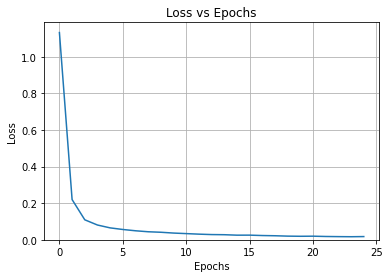

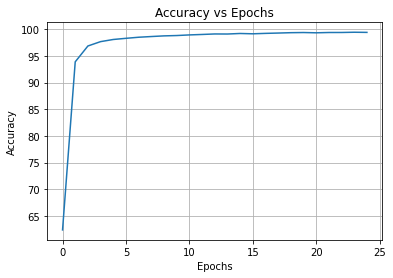

In [21]:
visualize_loss_accuracy(epochloss,epochAccuracy)

In [22]:
test(model_sigmoid1,device,test_dataloader)


Test set: Average loss: 0.0331, Accuracy: 9895/10000 (99%)



### Observations

* We observe that the accuracy of our prediction model with sigmoid has decreased significantly, the reason ReLU performs better than sigmoid is because of the ability of ReLU to deal with vanishing gradient problem. In sigmoid function when the x is large the gradient calculated are near to zero which degrades the model. Also it is seen that model with RelU is faster than sigmoid, this is because the ReLU brings in sparsity to our network by converting negative values to zero.

* It is important to note that Sigmoid has some advantage over ReLU when it comes to dealing with exploding gradient problem

# Question 6

Train the network defined in Question-1 with a different optimiser other than Adam, do you see any difference in performance? Substantiate your observations with relevant explanations.

In [23]:
%%time
model_RMSProp = Net().to(device)
optimizer = optim.RMSprop(model_RMSProp.parameters(), lr=0.001, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)
epochloss = []
epochAccuracy = []
epochs = 25
for epoch in range(1,epochs+1):
    loss,accuracy = train(model_RMSProp,device,train_dataloader,optimizer,epoch)
    epochloss.append(loss)
    epochAccuracy.append(accuracy)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.304381
Train Epoch: 1 [640/60000 (1%)]	Loss: 1.387457
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.823390
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.683489
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.732837
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.416912
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.255529
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.152173
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.215648
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.435712
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.215534
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.248751
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.192399
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.081017
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.186328
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.400961
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.129878
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.069274
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.188616
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.228651
Train Epoch: 1 [12800/60000 (

Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.012184
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.013417
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.008369
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.278661
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.000603
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.061939
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.282626
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.180397
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.336544
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.033656
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.085374
Train Epoch: 2 [53120/60000 (89%)]	Loss: 0.204450
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.017038
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.130501
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.029413
Train Epoch: 2 [55680/60000 (93%)]	Loss: 0.090515
Train Epoch: 2 [56320/60000 (94%)]	Loss: 0.028862
Train Epoch: 2 [56960/60000 (95%)]	Loss: 0.288315
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.235940
Train Epoch: 2 [58240/60000 (97%)]	Loss: 0.088344


Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.022755
Train Epoch: 4 [32640/60000 (54%)]	Loss: 0.034848
Train Epoch: 4 [33280/60000 (55%)]	Loss: 0.030123
Train Epoch: 4 [33920/60000 (57%)]	Loss: 0.033109
Train Epoch: 4 [34560/60000 (58%)]	Loss: 0.315519
Train Epoch: 4 [35200/60000 (59%)]	Loss: 0.108657
Train Epoch: 4 [35840/60000 (60%)]	Loss: 0.028635
Train Epoch: 4 [36480/60000 (61%)]	Loss: 0.004526
Train Epoch: 4 [37120/60000 (62%)]	Loss: 0.100932
Train Epoch: 4 [37760/60000 (63%)]	Loss: 0.001207
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.038501
Train Epoch: 4 [39040/60000 (65%)]	Loss: 0.064672
Train Epoch: 4 [39680/60000 (66%)]	Loss: 0.001072
Train Epoch: 4 [40320/60000 (67%)]	Loss: 0.017416
Train Epoch: 4 [40960/60000 (68%)]	Loss: 0.019686
Train Epoch: 4 [41600/60000 (69%)]	Loss: 0.009237
Train Epoch: 4 [42240/60000 (70%)]	Loss: 0.010683
Train Epoch: 4 [42880/60000 (71%)]	Loss: 0.009836
Train Epoch: 4 [43520/60000 (73%)]	Loss: 0.088854
Train Epoch: 4 [44160/60000 (74%)]	Loss: 0.011380


Train Epoch: 6 [17920/60000 (30%)]	Loss: 0.070856
Train Epoch: 6 [18560/60000 (31%)]	Loss: 0.003813
Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.002497
Train Epoch: 6 [19840/60000 (33%)]	Loss: 0.078958
Train Epoch: 6 [20480/60000 (34%)]	Loss: 0.011018
Train Epoch: 6 [21120/60000 (35%)]	Loss: 0.001266
Train Epoch: 6 [21760/60000 (36%)]	Loss: 0.000489
Train Epoch: 6 [22400/60000 (37%)]	Loss: 0.022498
Train Epoch: 6 [23040/60000 (38%)]	Loss: 0.008517
Train Epoch: 6 [23680/60000 (39%)]	Loss: 0.001162
Train Epoch: 6 [24320/60000 (41%)]	Loss: 0.004638
Train Epoch: 6 [24960/60000 (42%)]	Loss: 0.001012
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.027316
Train Epoch: 6 [26240/60000 (44%)]	Loss: 0.015520
Train Epoch: 6 [26880/60000 (45%)]	Loss: 0.004547
Train Epoch: 6 [27520/60000 (46%)]	Loss: 0.002733
Train Epoch: 6 [28160/60000 (47%)]	Loss: 0.002305
Train Epoch: 6 [28800/60000 (48%)]	Loss: 0.119600
Train Epoch: 6 [29440/60000 (49%)]	Loss: 0.032190
Train Epoch: 6 [30080/60000 (50%)]	Loss: 0.017265


Train Epoch: 8 [3200/60000 (5%)]	Loss: 0.002255
Train Epoch: 8 [3840/60000 (6%)]	Loss: 0.055149
Train Epoch: 8 [4480/60000 (7%)]	Loss: 0.000668
Train Epoch: 8 [5120/60000 (9%)]	Loss: 0.018694
Train Epoch: 8 [5760/60000 (10%)]	Loss: 0.400462
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.018401
Train Epoch: 8 [7040/60000 (12%)]	Loss: 0.001396
Train Epoch: 8 [7680/60000 (13%)]	Loss: 0.074039
Train Epoch: 8 [8320/60000 (14%)]	Loss: 0.008591
Train Epoch: 8 [8960/60000 (15%)]	Loss: 0.003159
Train Epoch: 8 [9600/60000 (16%)]	Loss: 0.009756
Train Epoch: 8 [10240/60000 (17%)]	Loss: 0.012522
Train Epoch: 8 [10880/60000 (18%)]	Loss: 0.023804
Train Epoch: 8 [11520/60000 (19%)]	Loss: 0.001080
Train Epoch: 8 [12160/60000 (20%)]	Loss: 0.301686
Train Epoch: 8 [12800/60000 (21%)]	Loss: 0.026534
Train Epoch: 8 [13440/60000 (22%)]	Loss: 0.000947
Train Epoch: 8 [14080/60000 (23%)]	Loss: 0.008987
Train Epoch: 8 [14720/60000 (25%)]	Loss: 0.009835
Train Epoch: 8 [15360/60000 (26%)]	Loss: 0.007992
Train Epoch: 8 

Train Epoch: 9 [48640/60000 (81%)]	Loss: 0.000935
Train Epoch: 9 [49280/60000 (82%)]	Loss: 0.062559
Train Epoch: 9 [49920/60000 (83%)]	Loss: 0.000737
Train Epoch: 9 [50560/60000 (84%)]	Loss: 0.000722
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.017028
Train Epoch: 9 [51840/60000 (86%)]	Loss: 0.000092
Train Epoch: 9 [52480/60000 (87%)]	Loss: 0.124374
Train Epoch: 9 [53120/60000 (89%)]	Loss: 0.062316
Train Epoch: 9 [53760/60000 (90%)]	Loss: 0.011826
Train Epoch: 9 [54400/60000 (91%)]	Loss: 0.001877
Train Epoch: 9 [55040/60000 (92%)]	Loss: 0.177566
Train Epoch: 9 [55680/60000 (93%)]	Loss: 0.033175
Train Epoch: 9 [56320/60000 (94%)]	Loss: 0.167641
Train Epoch: 9 [56960/60000 (95%)]	Loss: 0.070285
Train Epoch: 9 [57600/60000 (96%)]	Loss: 0.001951
Train Epoch: 9 [58240/60000 (97%)]	Loss: 0.171432
Train Epoch: 9 [58880/60000 (98%)]	Loss: 0.089711
Train Epoch: 9 [59520/60000 (99%)]	Loss: 0.107526
Train Epoch: 10 [0/60000 (0%)]	Loss: 0.136399
Train Epoch: 10 [640/60000 (1%)]	Loss: 0.089358
Train 

Train Epoch: 11 [32640/60000 (54%)]	Loss: 0.004978
Train Epoch: 11 [33280/60000 (55%)]	Loss: 0.010710
Train Epoch: 11 [33920/60000 (57%)]	Loss: 0.023461
Train Epoch: 11 [34560/60000 (58%)]	Loss: 0.003241
Train Epoch: 11 [35200/60000 (59%)]	Loss: 0.000821
Train Epoch: 11 [35840/60000 (60%)]	Loss: 0.010321
Train Epoch: 11 [36480/60000 (61%)]	Loss: 0.001353
Train Epoch: 11 [37120/60000 (62%)]	Loss: 0.005625
Train Epoch: 11 [37760/60000 (63%)]	Loss: 0.002024
Train Epoch: 11 [38400/60000 (64%)]	Loss: 0.190814
Train Epoch: 11 [39040/60000 (65%)]	Loss: 0.000688
Train Epoch: 11 [39680/60000 (66%)]	Loss: 0.001880
Train Epoch: 11 [40320/60000 (67%)]	Loss: 0.005166
Train Epoch: 11 [40960/60000 (68%)]	Loss: 0.009590
Train Epoch: 11 [41600/60000 (69%)]	Loss: 0.049608
Train Epoch: 11 [42240/60000 (70%)]	Loss: 0.005800
Train Epoch: 11 [42880/60000 (71%)]	Loss: 0.001555
Train Epoch: 11 [43520/60000 (73%)]	Loss: 0.005097
Train Epoch: 11 [44160/60000 (74%)]	Loss: 0.245391
Train Epoch: 11 [44800/60000 (7

Train Epoch: 13 [16000/60000 (27%)]	Loss: 0.037573
Train Epoch: 13 [16640/60000 (28%)]	Loss: 0.001550
Train Epoch: 13 [17280/60000 (29%)]	Loss: 0.256052
Train Epoch: 13 [17920/60000 (30%)]	Loss: 0.005589
Train Epoch: 13 [18560/60000 (31%)]	Loss: 0.001472
Train Epoch: 13 [19200/60000 (32%)]	Loss: 0.004635
Train Epoch: 13 [19840/60000 (33%)]	Loss: 0.001370
Train Epoch: 13 [20480/60000 (34%)]	Loss: 0.084977
Train Epoch: 13 [21120/60000 (35%)]	Loss: 0.033220
Train Epoch: 13 [21760/60000 (36%)]	Loss: 0.001535
Train Epoch: 13 [22400/60000 (37%)]	Loss: 0.054691
Train Epoch: 13 [23040/60000 (38%)]	Loss: 0.035585
Train Epoch: 13 [23680/60000 (39%)]	Loss: 0.045411
Train Epoch: 13 [24320/60000 (41%)]	Loss: 0.000633
Train Epoch: 13 [24960/60000 (42%)]	Loss: 0.009226
Train Epoch: 13 [25600/60000 (43%)]	Loss: 0.243405
Train Epoch: 13 [26240/60000 (44%)]	Loss: 0.018515
Train Epoch: 13 [26880/60000 (45%)]	Loss: 0.114081
Train Epoch: 13 [27520/60000 (46%)]	Loss: 0.001283
Train Epoch: 13 [28160/60000 (4

Train Epoch: 14 [59520/60000 (99%)]	Loss: 0.025099
Train Epoch: 15 [0/60000 (0%)]	Loss: 0.017844
Train Epoch: 15 [640/60000 (1%)]	Loss: 0.018020
Train Epoch: 15 [1280/60000 (2%)]	Loss: 0.002283
Train Epoch: 15 [1920/60000 (3%)]	Loss: 0.000556
Train Epoch: 15 [2560/60000 (4%)]	Loss: 0.020726
Train Epoch: 15 [3200/60000 (5%)]	Loss: 0.000391
Train Epoch: 15 [3840/60000 (6%)]	Loss: 0.014990
Train Epoch: 15 [4480/60000 (7%)]	Loss: 0.015768
Train Epoch: 15 [5120/60000 (9%)]	Loss: 0.031292
Train Epoch: 15 [5760/60000 (10%)]	Loss: 0.057866
Train Epoch: 15 [6400/60000 (11%)]	Loss: 0.001845
Train Epoch: 15 [7040/60000 (12%)]	Loss: 0.000710
Train Epoch: 15 [7680/60000 (13%)]	Loss: 0.089879
Train Epoch: 15 [8320/60000 (14%)]	Loss: 0.001972
Train Epoch: 15 [8960/60000 (15%)]	Loss: 0.000070
Train Epoch: 15 [9600/60000 (16%)]	Loss: 0.087951
Train Epoch: 15 [10240/60000 (17%)]	Loss: 0.120242
Train Epoch: 15 [10880/60000 (18%)]	Loss: 0.003097
Train Epoch: 15 [11520/60000 (19%)]	Loss: 0.018111
Train Epo

Train Epoch: 16 [42880/60000 (71%)]	Loss: 0.026754
Train Epoch: 16 [43520/60000 (73%)]	Loss: 0.035209
Train Epoch: 16 [44160/60000 (74%)]	Loss: 0.012697
Train Epoch: 16 [44800/60000 (75%)]	Loss: 0.187900
Train Epoch: 16 [45440/60000 (76%)]	Loss: 0.002372
Train Epoch: 16 [46080/60000 (77%)]	Loss: 0.000467
Train Epoch: 16 [46720/60000 (78%)]	Loss: 0.000501
Train Epoch: 16 [47360/60000 (79%)]	Loss: 0.013391
Train Epoch: 16 [48000/60000 (80%)]	Loss: 0.000473
Train Epoch: 16 [48640/60000 (81%)]	Loss: 0.000092
Train Epoch: 16 [49280/60000 (82%)]	Loss: 0.112663
Train Epoch: 16 [49920/60000 (83%)]	Loss: 0.077590
Train Epoch: 16 [50560/60000 (84%)]	Loss: 0.001993
Train Epoch: 16 [51200/60000 (85%)]	Loss: 0.016201
Train Epoch: 16 [51840/60000 (86%)]	Loss: 0.194380
Train Epoch: 16 [52480/60000 (87%)]	Loss: 0.002953
Train Epoch: 16 [53120/60000 (89%)]	Loss: 0.004660
Train Epoch: 16 [53760/60000 (90%)]	Loss: 0.001741
Train Epoch: 16 [54400/60000 (91%)]	Loss: 0.014479
Train Epoch: 16 [55040/60000 (9

Train Epoch: 18 [26240/60000 (44%)]	Loss: 0.016429
Train Epoch: 18 [26880/60000 (45%)]	Loss: 0.009130
Train Epoch: 18 [27520/60000 (46%)]	Loss: 0.000457
Train Epoch: 18 [28160/60000 (47%)]	Loss: 0.000093
Train Epoch: 18 [28800/60000 (48%)]	Loss: 0.001679
Train Epoch: 18 [29440/60000 (49%)]	Loss: 0.000592
Train Epoch: 18 [30080/60000 (50%)]	Loss: 0.011713
Train Epoch: 18 [30720/60000 (51%)]	Loss: 0.003191
Train Epoch: 18 [31360/60000 (52%)]	Loss: 0.000261
Train Epoch: 18 [32000/60000 (53%)]	Loss: 0.030507
Train Epoch: 18 [32640/60000 (54%)]	Loss: 0.000675
Train Epoch: 18 [33280/60000 (55%)]	Loss: 0.000453
Train Epoch: 18 [33920/60000 (57%)]	Loss: 0.002155
Train Epoch: 18 [34560/60000 (58%)]	Loss: 0.098363
Train Epoch: 18 [35200/60000 (59%)]	Loss: 0.059830
Train Epoch: 18 [35840/60000 (60%)]	Loss: 0.111252
Train Epoch: 18 [36480/60000 (61%)]	Loss: 0.011484
Train Epoch: 18 [37120/60000 (62%)]	Loss: 0.031794
Train Epoch: 18 [37760/60000 (63%)]	Loss: 0.012676
Train Epoch: 18 [38400/60000 (6

Train Epoch: 20 [9600/60000 (16%)]	Loss: 0.000199
Train Epoch: 20 [10240/60000 (17%)]	Loss: 0.024465
Train Epoch: 20 [10880/60000 (18%)]	Loss: 0.001404
Train Epoch: 20 [11520/60000 (19%)]	Loss: 0.013844
Train Epoch: 20 [12160/60000 (20%)]	Loss: 0.019795
Train Epoch: 20 [12800/60000 (21%)]	Loss: 0.003231
Train Epoch: 20 [13440/60000 (22%)]	Loss: 0.005791
Train Epoch: 20 [14080/60000 (23%)]	Loss: 0.005814
Train Epoch: 20 [14720/60000 (25%)]	Loss: 0.000699
Train Epoch: 20 [15360/60000 (26%)]	Loss: 0.003332
Train Epoch: 20 [16000/60000 (27%)]	Loss: 0.030532
Train Epoch: 20 [16640/60000 (28%)]	Loss: 0.003124
Train Epoch: 20 [17280/60000 (29%)]	Loss: 0.078955
Train Epoch: 20 [17920/60000 (30%)]	Loss: 0.000055
Train Epoch: 20 [18560/60000 (31%)]	Loss: 0.219040
Train Epoch: 20 [19200/60000 (32%)]	Loss: 0.004326
Train Epoch: 20 [19840/60000 (33%)]	Loss: 0.179785
Train Epoch: 20 [20480/60000 (34%)]	Loss: 0.012991
Train Epoch: 20 [21120/60000 (35%)]	Loss: 0.000592
Train Epoch: 20 [21760/60000 (36

Train Epoch: 21 [53120/60000 (89%)]	Loss: 0.204426
Train Epoch: 21 [53760/60000 (90%)]	Loss: 0.001663
Train Epoch: 21 [54400/60000 (91%)]	Loss: 0.006118
Train Epoch: 21 [55040/60000 (92%)]	Loss: 0.064368
Train Epoch: 21 [55680/60000 (93%)]	Loss: 0.004382
Train Epoch: 21 [56320/60000 (94%)]	Loss: 0.003164
Train Epoch: 21 [56960/60000 (95%)]	Loss: 0.012545
Train Epoch: 21 [57600/60000 (96%)]	Loss: 0.119447
Train Epoch: 21 [58240/60000 (97%)]	Loss: 0.005571
Train Epoch: 21 [58880/60000 (98%)]	Loss: 0.000732
Train Epoch: 21 [59520/60000 (99%)]	Loss: 0.006831
Train Epoch: 22 [0/60000 (0%)]	Loss: 0.000787
Train Epoch: 22 [640/60000 (1%)]	Loss: 0.002713
Train Epoch: 22 [1280/60000 (2%)]	Loss: 0.000151
Train Epoch: 22 [1920/60000 (3%)]	Loss: 0.000822
Train Epoch: 22 [2560/60000 (4%)]	Loss: 0.046448
Train Epoch: 22 [3200/60000 (5%)]	Loss: 0.025920
Train Epoch: 22 [3840/60000 (6%)]	Loss: 0.132291
Train Epoch: 22 [4480/60000 (7%)]	Loss: 0.006435
Train Epoch: 22 [5120/60000 (9%)]	Loss: 0.001650
Tr

Train Epoch: 23 [36480/60000 (61%)]	Loss: 0.603631
Train Epoch: 23 [37120/60000 (62%)]	Loss: 0.005032
Train Epoch: 23 [37760/60000 (63%)]	Loss: 0.226165
Train Epoch: 23 [38400/60000 (64%)]	Loss: 0.381718
Train Epoch: 23 [39040/60000 (65%)]	Loss: 0.002844
Train Epoch: 23 [39680/60000 (66%)]	Loss: 0.688823
Train Epoch: 23 [40320/60000 (67%)]	Loss: 0.012017
Train Epoch: 23 [40960/60000 (68%)]	Loss: 0.001678
Train Epoch: 23 [41600/60000 (69%)]	Loss: 0.013601
Train Epoch: 23 [42240/60000 (70%)]	Loss: 0.016698
Train Epoch: 23 [42880/60000 (71%)]	Loss: 0.045833
Train Epoch: 23 [43520/60000 (73%)]	Loss: 0.006817
Train Epoch: 23 [44160/60000 (74%)]	Loss: 0.041047
Train Epoch: 23 [44800/60000 (75%)]	Loss: 0.037090
Train Epoch: 23 [45440/60000 (76%)]	Loss: 0.037254
Train Epoch: 23 [46080/60000 (77%)]	Loss: 0.000445
Train Epoch: 23 [46720/60000 (78%)]	Loss: 0.000564
Train Epoch: 23 [47360/60000 (79%)]	Loss: 0.000347
Train Epoch: 23 [48000/60000 (80%)]	Loss: 0.001360
Train Epoch: 23 [48640/60000 (8

Train Epoch: 25 [19840/60000 (33%)]	Loss: 0.001185
Train Epoch: 25 [20480/60000 (34%)]	Loss: 0.007419
Train Epoch: 25 [21120/60000 (35%)]	Loss: 0.007769
Train Epoch: 25 [21760/60000 (36%)]	Loss: 0.012248
Train Epoch: 25 [22400/60000 (37%)]	Loss: 0.001173
Train Epoch: 25 [23040/60000 (38%)]	Loss: 0.168255
Train Epoch: 25 [23680/60000 (39%)]	Loss: 0.188392
Train Epoch: 25 [24320/60000 (41%)]	Loss: 0.007526
Train Epoch: 25 [24960/60000 (42%)]	Loss: 0.000110
Train Epoch: 25 [25600/60000 (43%)]	Loss: 0.010619
Train Epoch: 25 [26240/60000 (44%)]	Loss: 0.001034
Train Epoch: 25 [26880/60000 (45%)]	Loss: 0.000310
Train Epoch: 25 [27520/60000 (46%)]	Loss: 0.082334
Train Epoch: 25 [28160/60000 (47%)]	Loss: 0.161175
Train Epoch: 25 [28800/60000 (48%)]	Loss: 0.104358
Train Epoch: 25 [29440/60000 (49%)]	Loss: 0.005125
Train Epoch: 25 [30080/60000 (50%)]	Loss: 0.011839
Train Epoch: 25 [30720/60000 (51%)]	Loss: 0.048916
Train Epoch: 25 [31360/60000 (52%)]	Loss: 0.012670
Train Epoch: 25 [32000/60000 (5

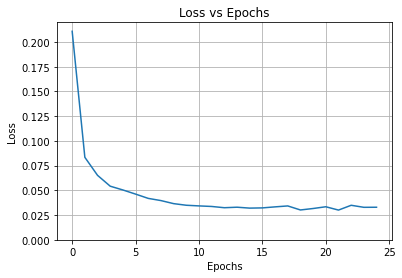

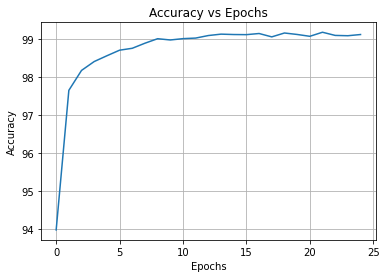

In [24]:
visualize_loss_accuracy(epochloss,epochAccuracy)

In [25]:
test(model_RMSProp,device,test_dataloader)


Test set: Average loss: 0.0269, Accuracy: 9931/10000 (99%)



### Observation for question-6 

RMSprop uses an adaptive learning rate which is better than using constant learning rate as Hyperparameter. RMSprop uses the running squared average of gradients in mini-batch to normalize the gradient direction. Also RMSprop is helpful in dealing with problem of exploding gradient and vanishing gradient by increasing the momentum (momentum controls the size of steps.) if gradients are vanishing and decreasing the momentum if the gradients are exploding. 






# Question 7

Initialize the `Conv2d` layers in the network defined in Question-1 `(Net)` with all ones (both weights and bias). Train the network with Adam optimizer and report the final test accuracy. Is there any difference in the performance? If yes, what do you think is the reason? 

In [26]:
def weights_init1(m):
    if type(m) == (nn.Conv2d):
        m.weight.data.fill_(1)
        m.bias.data.fill_(1)


In [27]:
%%time
model17 = Net().to(device)
optimizer = optim.Adam(model17.parameters(),lr=0.001)
model17.apply(weights_init1)
epochloss = []
epochAccuracy = []
epochs = 25
for epoch in range(1,epochs+1):
    loss,accuracy = train(model17,device,train_dataloader,optimizer,epoch)
    epochloss.append(loss)
    epochAccuracy.append(accuracy)

Train Epoch: 1 [0/60000 (0%)]	Loss: 211202.843750
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.240727
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.305697
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.298949
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.299258
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.301594
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.236092
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.236946
Train Epoch: 1 [5120/60000 (9%)]	Loss: 291.223145
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.308211
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.222680
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.313051
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.233034
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.226736
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.300111
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.302014
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.297206
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.311283
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.289578
Train Epoch: 1 [12160/60000 (20%)]	Loss: 2.291088
Train Epoch: 1 [12800/

Train Epoch: 2 [45440/60000 (76%)]	Loss: 2.314209
Train Epoch: 2 [46080/60000 (77%)]	Loss: 2.295113
Train Epoch: 2 [46720/60000 (78%)]	Loss: 2.294257
Train Epoch: 2 [47360/60000 (79%)]	Loss: 2.286402
Train Epoch: 2 [48000/60000 (80%)]	Loss: 2.289052
Train Epoch: 2 [48640/60000 (81%)]	Loss: 2.305304
Train Epoch: 2 [49280/60000 (82%)]	Loss: 2.296623
Train Epoch: 2 [49920/60000 (83%)]	Loss: 2.305243
Train Epoch: 2 [50560/60000 (84%)]	Loss: 2.299729
Train Epoch: 2 [51200/60000 (85%)]	Loss: 2.291592
Train Epoch: 2 [51840/60000 (86%)]	Loss: 2.282312
Train Epoch: 2 [52480/60000 (87%)]	Loss: 2.294930
Train Epoch: 2 [53120/60000 (89%)]	Loss: 2.301787
Train Epoch: 2 [53760/60000 (90%)]	Loss: 2.291352
Train Epoch: 2 [54400/60000 (91%)]	Loss: 2.311591
Train Epoch: 2 [55040/60000 (92%)]	Loss: 2.299047
Train Epoch: 2 [55680/60000 (93%)]	Loss: 2.314046
Train Epoch: 2 [56320/60000 (94%)]	Loss: 2.303015
Train Epoch: 2 [56960/60000 (95%)]	Loss: 2.300745
Train Epoch: 2 [57600/60000 (96%)]	Loss: 2.295214


Train Epoch: 4 [31360/60000 (52%)]	Loss: 2.307576
Train Epoch: 4 [32000/60000 (53%)]	Loss: 2.316787
Train Epoch: 4 [32640/60000 (54%)]	Loss: 2.288939
Train Epoch: 4 [33280/60000 (55%)]	Loss: 2.296723
Train Epoch: 4 [33920/60000 (57%)]	Loss: 2.299591
Train Epoch: 4 [34560/60000 (58%)]	Loss: 2.313402
Train Epoch: 4 [35200/60000 (59%)]	Loss: 2.297617
Train Epoch: 4 [35840/60000 (60%)]	Loss: 2.306108
Train Epoch: 4 [36480/60000 (61%)]	Loss: 2.295737
Train Epoch: 4 [37120/60000 (62%)]	Loss: 2.299772
Train Epoch: 4 [37760/60000 (63%)]	Loss: 2.294732
Train Epoch: 4 [38400/60000 (64%)]	Loss: 2.282000
Train Epoch: 4 [39040/60000 (65%)]	Loss: 2.307058
Train Epoch: 4 [39680/60000 (66%)]	Loss: 2.291181
Train Epoch: 4 [40320/60000 (67%)]	Loss: 2.304958
Train Epoch: 4 [40960/60000 (68%)]	Loss: 2.317500
Train Epoch: 4 [41600/60000 (69%)]	Loss: 2.305394
Train Epoch: 4 [42240/60000 (70%)]	Loss: 2.311015
Train Epoch: 4 [42880/60000 (71%)]	Loss: 2.304598
Train Epoch: 4 [43520/60000 (73%)]	Loss: 2.288339


Train Epoch: 6 [17280/60000 (29%)]	Loss: 2.299133
Train Epoch: 6 [17920/60000 (30%)]	Loss: 2.314106
Train Epoch: 6 [18560/60000 (31%)]	Loss: 2.305896
Train Epoch: 6 [19200/60000 (32%)]	Loss: 2.296727
Train Epoch: 6 [19840/60000 (33%)]	Loss: 2.294483
Train Epoch: 6 [20480/60000 (34%)]	Loss: 2.309980
Train Epoch: 6 [21120/60000 (35%)]	Loss: 2.316158
Train Epoch: 6 [21760/60000 (36%)]	Loss: 2.300749
Train Epoch: 6 [22400/60000 (37%)]	Loss: 2.304075
Train Epoch: 6 [23040/60000 (38%)]	Loss: 2.294136
Train Epoch: 6 [23680/60000 (39%)]	Loss: 2.297915
Train Epoch: 6 [24320/60000 (41%)]	Loss: 2.279453
Train Epoch: 6 [24960/60000 (42%)]	Loss: 2.288044
Train Epoch: 6 [25600/60000 (43%)]	Loss: 2.288189
Train Epoch: 6 [26240/60000 (44%)]	Loss: 2.307224
Train Epoch: 6 [26880/60000 (45%)]	Loss: 2.299433
Train Epoch: 6 [27520/60000 (46%)]	Loss: 2.298948
Train Epoch: 6 [28160/60000 (47%)]	Loss: 2.297759
Train Epoch: 6 [28800/60000 (48%)]	Loss: 2.293841
Train Epoch: 6 [29440/60000 (49%)]	Loss: 2.289509


Train Epoch: 8 [2560/60000 (4%)]	Loss: 2.306484
Train Epoch: 8 [3200/60000 (5%)]	Loss: 2.304355
Train Epoch: 8 [3840/60000 (6%)]	Loss: 2.306341
Train Epoch: 8 [4480/60000 (7%)]	Loss: 2.293658
Train Epoch: 8 [5120/60000 (9%)]	Loss: 2.294641
Train Epoch: 8 [5760/60000 (10%)]	Loss: 2.287820
Train Epoch: 8 [6400/60000 (11%)]	Loss: 2.297335
Train Epoch: 8 [7040/60000 (12%)]	Loss: 2.292274
Train Epoch: 8 [7680/60000 (13%)]	Loss: 2.313423
Train Epoch: 8 [8320/60000 (14%)]	Loss: 2.293916
Train Epoch: 8 [8960/60000 (15%)]	Loss: 2.298590
Train Epoch: 8 [9600/60000 (16%)]	Loss: 2.294754
Train Epoch: 8 [10240/60000 (17%)]	Loss: 2.303756
Train Epoch: 8 [10880/60000 (18%)]	Loss: 2.300006
Train Epoch: 8 [11520/60000 (19%)]	Loss: 2.298618
Train Epoch: 8 [12160/60000 (20%)]	Loss: 2.302629
Train Epoch: 8 [12800/60000 (21%)]	Loss: 2.303614
Train Epoch: 8 [13440/60000 (22%)]	Loss: 2.286082
Train Epoch: 8 [14080/60000 (23%)]	Loss: 2.302488
Train Epoch: 8 [14720/60000 (25%)]	Loss: 2.296362
Train Epoch: 8 [1

Train Epoch: 9 [48000/60000 (80%)]	Loss: 2.310026
Train Epoch: 9 [48640/60000 (81%)]	Loss: 2.293298
Train Epoch: 9 [49280/60000 (82%)]	Loss: 2.282243
Train Epoch: 9 [49920/60000 (83%)]	Loss: 2.306367
Train Epoch: 9 [50560/60000 (84%)]	Loss: 2.301178
Train Epoch: 9 [51200/60000 (85%)]	Loss: 2.316295
Train Epoch: 9 [51840/60000 (86%)]	Loss: 2.308309
Train Epoch: 9 [52480/60000 (87%)]	Loss: 2.314859
Train Epoch: 9 [53120/60000 (89%)]	Loss: 2.301879
Train Epoch: 9 [53760/60000 (90%)]	Loss: 2.325429
Train Epoch: 9 [54400/60000 (91%)]	Loss: 2.290111
Train Epoch: 9 [55040/60000 (92%)]	Loss: 2.288368
Train Epoch: 9 [55680/60000 (93%)]	Loss: 2.297607
Train Epoch: 9 [56320/60000 (94%)]	Loss: 2.311784
Train Epoch: 9 [56960/60000 (95%)]	Loss: 2.302301
Train Epoch: 9 [57600/60000 (96%)]	Loss: 2.295305
Train Epoch: 9 [58240/60000 (97%)]	Loss: 2.306040
Train Epoch: 9 [58880/60000 (98%)]	Loss: 2.310231
Train Epoch: 9 [59520/60000 (99%)]	Loss: 2.310862
Train Epoch: 10 [0/60000 (0%)]	Loss: 2.317038
Trai

Train Epoch: 11 [32000/60000 (53%)]	Loss: 2.304362
Train Epoch: 11 [32640/60000 (54%)]	Loss: 2.290683
Train Epoch: 11 [33280/60000 (55%)]	Loss: 2.292623
Train Epoch: 11 [33920/60000 (57%)]	Loss: 2.309872
Train Epoch: 11 [34560/60000 (58%)]	Loss: 2.319091
Train Epoch: 11 [35200/60000 (59%)]	Loss: 2.295713
Train Epoch: 11 [35840/60000 (60%)]	Loss: 2.294667
Train Epoch: 11 [36480/60000 (61%)]	Loss: 2.302240
Train Epoch: 11 [37120/60000 (62%)]	Loss: 2.287368
Train Epoch: 11 [37760/60000 (63%)]	Loss: 2.299952
Train Epoch: 11 [38400/60000 (64%)]	Loss: 2.323156
Train Epoch: 11 [39040/60000 (65%)]	Loss: 2.304387
Train Epoch: 11 [39680/60000 (66%)]	Loss: 2.310525
Train Epoch: 11 [40320/60000 (67%)]	Loss: 2.282982
Train Epoch: 11 [40960/60000 (68%)]	Loss: 2.298952
Train Epoch: 11 [41600/60000 (69%)]	Loss: 2.282779
Train Epoch: 11 [42240/60000 (70%)]	Loss: 2.280743
Train Epoch: 11 [42880/60000 (71%)]	Loss: 2.318324
Train Epoch: 11 [43520/60000 (73%)]	Loss: 2.290976
Train Epoch: 11 [44160/60000 (7

Train Epoch: 13 [15360/60000 (26%)]	Loss: 2.299971
Train Epoch: 13 [16000/60000 (27%)]	Loss: 2.318950
Train Epoch: 13 [16640/60000 (28%)]	Loss: 2.296496
Train Epoch: 13 [17280/60000 (29%)]	Loss: 2.290495
Train Epoch: 13 [17920/60000 (30%)]	Loss: 2.296767
Train Epoch: 13 [18560/60000 (31%)]	Loss: 2.312872
Train Epoch: 13 [19200/60000 (32%)]	Loss: 2.301072
Train Epoch: 13 [19840/60000 (33%)]	Loss: 2.306565
Train Epoch: 13 [20480/60000 (34%)]	Loss: 2.301631
Train Epoch: 13 [21120/60000 (35%)]	Loss: 2.304923
Train Epoch: 13 [21760/60000 (36%)]	Loss: 2.294737
Train Epoch: 13 [22400/60000 (37%)]	Loss: 2.288096
Train Epoch: 13 [23040/60000 (38%)]	Loss: 2.287073
Train Epoch: 13 [23680/60000 (39%)]	Loss: 2.309200
Train Epoch: 13 [24320/60000 (41%)]	Loss: 2.320208
Train Epoch: 13 [24960/60000 (42%)]	Loss: 2.277441
Train Epoch: 13 [25600/60000 (43%)]	Loss: 2.301347
Train Epoch: 13 [26240/60000 (44%)]	Loss: 2.302450
Train Epoch: 13 [26880/60000 (45%)]	Loss: 2.323016
Train Epoch: 13 [27520/60000 (4

Train Epoch: 14 [58880/60000 (98%)]	Loss: 2.301008
Train Epoch: 14 [59520/60000 (99%)]	Loss: 2.301093
Train Epoch: 15 [0/60000 (0%)]	Loss: 2.296946
Train Epoch: 15 [640/60000 (1%)]	Loss: 2.289435
Train Epoch: 15 [1280/60000 (2%)]	Loss: 2.289827
Train Epoch: 15 [1920/60000 (3%)]	Loss: 2.293433
Train Epoch: 15 [2560/60000 (4%)]	Loss: 2.311375
Train Epoch: 15 [3200/60000 (5%)]	Loss: 2.313949
Train Epoch: 15 [3840/60000 (6%)]	Loss: 2.304136
Train Epoch: 15 [4480/60000 (7%)]	Loss: 2.313630
Train Epoch: 15 [5120/60000 (9%)]	Loss: 2.277609
Train Epoch: 15 [5760/60000 (10%)]	Loss: 2.312949
Train Epoch: 15 [6400/60000 (11%)]	Loss: 2.289829
Train Epoch: 15 [7040/60000 (12%)]	Loss: 2.312281
Train Epoch: 15 [7680/60000 (13%)]	Loss: 2.316806
Train Epoch: 15 [8320/60000 (14%)]	Loss: 2.309179
Train Epoch: 15 [8960/60000 (15%)]	Loss: 2.304515
Train Epoch: 15 [9600/60000 (16%)]	Loss: 2.301286
Train Epoch: 15 [10240/60000 (17%)]	Loss: 2.295294
Train Epoch: 15 [10880/60000 (18%)]	Loss: 2.306227
Train Epo

Train Epoch: 16 [42240/60000 (70%)]	Loss: 2.306519
Train Epoch: 16 [42880/60000 (71%)]	Loss: 2.288990
Train Epoch: 16 [43520/60000 (73%)]	Loss: 2.291614
Train Epoch: 16 [44160/60000 (74%)]	Loss: 2.319338
Train Epoch: 16 [44800/60000 (75%)]	Loss: 2.304076
Train Epoch: 16 [45440/60000 (76%)]	Loss: 2.298951
Train Epoch: 16 [46080/60000 (77%)]	Loss: 2.300009
Train Epoch: 16 [46720/60000 (78%)]	Loss: 2.299719
Train Epoch: 16 [47360/60000 (79%)]	Loss: 2.301531
Train Epoch: 16 [48000/60000 (80%)]	Loss: 2.297676
Train Epoch: 16 [48640/60000 (81%)]	Loss: 2.297825
Train Epoch: 16 [49280/60000 (82%)]	Loss: 2.310752
Train Epoch: 16 [49920/60000 (83%)]	Loss: 2.318331
Train Epoch: 16 [50560/60000 (84%)]	Loss: 2.313207
Train Epoch: 16 [51200/60000 (85%)]	Loss: 2.303988
Train Epoch: 16 [51840/60000 (86%)]	Loss: 2.287558
Train Epoch: 16 [52480/60000 (87%)]	Loss: 2.299903
Train Epoch: 16 [53120/60000 (89%)]	Loss: 2.312604
Train Epoch: 16 [53760/60000 (90%)]	Loss: 2.304431
Train Epoch: 16 [54400/60000 (9

Train Epoch: 18 [25600/60000 (43%)]	Loss: 2.306945
Train Epoch: 18 [26240/60000 (44%)]	Loss: 2.308078
Train Epoch: 18 [26880/60000 (45%)]	Loss: 2.311215
Train Epoch: 18 [27520/60000 (46%)]	Loss: 2.318199
Train Epoch: 18 [28160/60000 (47%)]	Loss: 2.302953
Train Epoch: 18 [28800/60000 (48%)]	Loss: 2.310464
Train Epoch: 18 [29440/60000 (49%)]	Loss: 2.311839
Train Epoch: 18 [30080/60000 (50%)]	Loss: 2.303822
Train Epoch: 18 [30720/60000 (51%)]	Loss: 2.296316
Train Epoch: 18 [31360/60000 (52%)]	Loss: 2.294343
Train Epoch: 18 [32000/60000 (53%)]	Loss: 2.312217
Train Epoch: 18 [32640/60000 (54%)]	Loss: 2.303362
Train Epoch: 18 [33280/60000 (55%)]	Loss: 2.308736
Train Epoch: 18 [33920/60000 (57%)]	Loss: 2.278750
Train Epoch: 18 [34560/60000 (58%)]	Loss: 2.291121
Train Epoch: 18 [35200/60000 (59%)]	Loss: 2.290064
Train Epoch: 18 [35840/60000 (60%)]	Loss: 2.308634
Train Epoch: 18 [36480/60000 (61%)]	Loss: 2.308939
Train Epoch: 18 [37120/60000 (62%)]	Loss: 2.292693
Train Epoch: 18 [37760/60000 (6

Train Epoch: 20 [8960/60000 (15%)]	Loss: 2.314958
Train Epoch: 20 [9600/60000 (16%)]	Loss: 2.297838
Train Epoch: 20 [10240/60000 (17%)]	Loss: 2.309868
Train Epoch: 20 [10880/60000 (18%)]	Loss: 2.288959
Train Epoch: 20 [11520/60000 (19%)]	Loss: 2.291244
Train Epoch: 20 [12160/60000 (20%)]	Loss: 2.309206
Train Epoch: 20 [12800/60000 (21%)]	Loss: 2.285226
Train Epoch: 20 [13440/60000 (22%)]	Loss: 2.296231
Train Epoch: 20 [14080/60000 (23%)]	Loss: 2.293374
Train Epoch: 20 [14720/60000 (25%)]	Loss: 2.314917
Train Epoch: 20 [15360/60000 (26%)]	Loss: 2.293123
Train Epoch: 20 [16000/60000 (27%)]	Loss: 2.306541
Train Epoch: 20 [16640/60000 (28%)]	Loss: 2.300005
Train Epoch: 20 [17280/60000 (29%)]	Loss: 2.305109
Train Epoch: 20 [17920/60000 (30%)]	Loss: 2.295962
Train Epoch: 20 [18560/60000 (31%)]	Loss: 2.287165
Train Epoch: 20 [19200/60000 (32%)]	Loss: 2.290984
Train Epoch: 20 [19840/60000 (33%)]	Loss: 2.302030
Train Epoch: 20 [20480/60000 (34%)]	Loss: 2.309900
Train Epoch: 20 [21120/60000 (35%

Train Epoch: 21 [52480/60000 (87%)]	Loss: 2.324852
Train Epoch: 21 [53120/60000 (89%)]	Loss: 2.302370
Train Epoch: 21 [53760/60000 (90%)]	Loss: 2.290511
Train Epoch: 21 [54400/60000 (91%)]	Loss: 2.309700
Train Epoch: 21 [55040/60000 (92%)]	Loss: 2.295460
Train Epoch: 21 [55680/60000 (93%)]	Loss: 2.309605
Train Epoch: 21 [56320/60000 (94%)]	Loss: 2.304631
Train Epoch: 21 [56960/60000 (95%)]	Loss: 2.292650
Train Epoch: 21 [57600/60000 (96%)]	Loss: 2.302167
Train Epoch: 21 [58240/60000 (97%)]	Loss: 2.320913
Train Epoch: 21 [58880/60000 (98%)]	Loss: 2.299441
Train Epoch: 21 [59520/60000 (99%)]	Loss: 2.291080
Train Epoch: 22 [0/60000 (0%)]	Loss: 2.308339
Train Epoch: 22 [640/60000 (1%)]	Loss: 2.305622
Train Epoch: 22 [1280/60000 (2%)]	Loss: 2.297698
Train Epoch: 22 [1920/60000 (3%)]	Loss: 2.294033
Train Epoch: 22 [2560/60000 (4%)]	Loss: 2.282040
Train Epoch: 22 [3200/60000 (5%)]	Loss: 2.298306
Train Epoch: 22 [3840/60000 (6%)]	Loss: 2.277862
Train Epoch: 22 [4480/60000 (7%)]	Loss: 2.318886


Train Epoch: 23 [35840/60000 (60%)]	Loss: 2.325505
Train Epoch: 23 [36480/60000 (61%)]	Loss: 2.306722
Train Epoch: 23 [37120/60000 (62%)]	Loss: 2.314505
Train Epoch: 23 [37760/60000 (63%)]	Loss: 2.311922
Train Epoch: 23 [38400/60000 (64%)]	Loss: 2.292808
Train Epoch: 23 [39040/60000 (65%)]	Loss: 2.296756
Train Epoch: 23 [39680/60000 (66%)]	Loss: 2.297498
Train Epoch: 23 [40320/60000 (67%)]	Loss: 2.314265
Train Epoch: 23 [40960/60000 (68%)]	Loss: 2.314982
Train Epoch: 23 [41600/60000 (69%)]	Loss: 2.304046
Train Epoch: 23 [42240/60000 (70%)]	Loss: 2.302395
Train Epoch: 23 [42880/60000 (71%)]	Loss: 2.298687
Train Epoch: 23 [43520/60000 (73%)]	Loss: 2.295564
Train Epoch: 23 [44160/60000 (74%)]	Loss: 2.287448
Train Epoch: 23 [44800/60000 (75%)]	Loss: 2.295637
Train Epoch: 23 [45440/60000 (76%)]	Loss: 2.298307
Train Epoch: 23 [46080/60000 (77%)]	Loss: 2.310669
Train Epoch: 23 [46720/60000 (78%)]	Loss: 2.288424
Train Epoch: 23 [47360/60000 (79%)]	Loss: 2.297840
Train Epoch: 23 [48000/60000 (8

Train Epoch: 25 [19200/60000 (32%)]	Loss: 2.308509
Train Epoch: 25 [19840/60000 (33%)]	Loss: 2.306370
Train Epoch: 25 [20480/60000 (34%)]	Loss: 2.310840
Train Epoch: 25 [21120/60000 (35%)]	Loss: 2.297357
Train Epoch: 25 [21760/60000 (36%)]	Loss: 2.304414
Train Epoch: 25 [22400/60000 (37%)]	Loss: 2.296157
Train Epoch: 25 [23040/60000 (38%)]	Loss: 2.306056
Train Epoch: 25 [23680/60000 (39%)]	Loss: 2.297740
Train Epoch: 25 [24320/60000 (41%)]	Loss: 2.287819
Train Epoch: 25 [24960/60000 (42%)]	Loss: 2.311592
Train Epoch: 25 [25600/60000 (43%)]	Loss: 2.292531
Train Epoch: 25 [26240/60000 (44%)]	Loss: 2.310925
Train Epoch: 25 [26880/60000 (45%)]	Loss: 2.305730
Train Epoch: 25 [27520/60000 (46%)]	Loss: 2.289520
Train Epoch: 25 [28160/60000 (47%)]	Loss: 2.301951
Train Epoch: 25 [28800/60000 (48%)]	Loss: 2.300049
Train Epoch: 25 [29440/60000 (49%)]	Loss: 2.293821
Train Epoch: 25 [30080/60000 (50%)]	Loss: 2.301584
Train Epoch: 25 [30720/60000 (51%)]	Loss: 2.288259
Train Epoch: 25 [31360/60000 (5

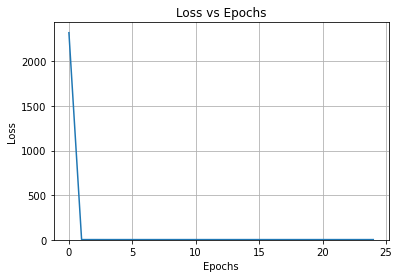

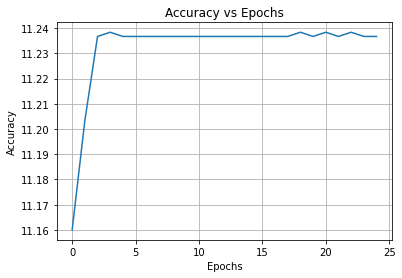

In [28]:
visualize_loss_accuracy(epochloss,epochAccuracy)

In [29]:
test(model17,device,test_dataloader)


Test set: Average loss: 2.3010, Accuracy: 1135/10000 (11%)



### Observations for question-7 constant weights and bias initialisation
We see that Constant initailization of weights and bias with 1, 1 respectively does not work well. This result can be backed up with an example of neural network with 2 inputs(x1,y1) and 1 hidden layer with 2 neurons with ReLU activation function. We assume initialization of all weights as some constant α and biases as 0. When we forward propogate in network the output of both hidden layer will be same and equal to ReLU(αx1 +αx2). This means that both hidden units will have same effect on cost which will give same gradient during backward propogation. And hence function all neurons in a layer will learn same things where else we want each unit to learn different things.

# Question 8

Initialize the network defined in Question-1 `(Net)` with Xavier's initialization ([torch.nn.init.xavier_normal](https://pytorch.org/docs/stable/nn.init.html))(for bias use zero). Train the network with Adam optimizer and report the final test accuracy.

In [30]:
def weights_init2(m):
    if type(m) == (nn.Conv2d or nn.Linear):
        nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0)
    


In [31]:
%%time
model18 = Net().to(device)

optimizer = optim.Adam(model18.parameters(),lr=0.001)
model18.apply(weights_init2)

epochloss = []
epochAccuracy = []
epochs = 25
for epoch in range(1,epochs+1):
    loss,accuracy = train(model18,device,train_dataloader,optimizer,epoch)
    epochloss.append(loss)
    epochAccuracy.append(accuracy)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.300111
Train Epoch: 1 [640/60000 (1%)]	Loss: 1.195660
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.593074
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.778522
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.317384
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.612066
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.346393
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.284141
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.106564
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.127024
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.207676
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.266334
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.445706
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.297304
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.169680
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.140160
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.319617
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.387813
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.817174
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.134301
Train Epoch: 1 [12800/60000 (

Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.010300
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.083717
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.050040
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.012250
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.157896
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.031487
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.046432
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.047454
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.022990
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.196693
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.294973
Train Epoch: 2 [53120/60000 (89%)]	Loss: 0.003079
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.019142
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.064921
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.092749
Train Epoch: 2 [55680/60000 (93%)]	Loss: 0.487938
Train Epoch: 2 [56320/60000 (94%)]	Loss: 0.011970
Train Epoch: 2 [56960/60000 (95%)]	Loss: 0.011496
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.092633
Train Epoch: 2 [58240/60000 (97%)]	Loss: 0.018348


Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.032612
Train Epoch: 4 [32640/60000 (54%)]	Loss: 0.173917
Train Epoch: 4 [33280/60000 (55%)]	Loss: 0.006032
Train Epoch: 4 [33920/60000 (57%)]	Loss: 0.062106
Train Epoch: 4 [34560/60000 (58%)]	Loss: 0.000460
Train Epoch: 4 [35200/60000 (59%)]	Loss: 0.180719
Train Epoch: 4 [35840/60000 (60%)]	Loss: 0.006648
Train Epoch: 4 [36480/60000 (61%)]	Loss: 0.002414
Train Epoch: 4 [37120/60000 (62%)]	Loss: 0.015569
Train Epoch: 4 [37760/60000 (63%)]	Loss: 0.025874
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.012736
Train Epoch: 4 [39040/60000 (65%)]	Loss: 0.007745
Train Epoch: 4 [39680/60000 (66%)]	Loss: 0.027837
Train Epoch: 4 [40320/60000 (67%)]	Loss: 0.015081
Train Epoch: 4 [40960/60000 (68%)]	Loss: 0.020324
Train Epoch: 4 [41600/60000 (69%)]	Loss: 0.003598
Train Epoch: 4 [42240/60000 (70%)]	Loss: 0.036929
Train Epoch: 4 [42880/60000 (71%)]	Loss: 0.020125
Train Epoch: 4 [43520/60000 (73%)]	Loss: 0.002441
Train Epoch: 4 [44160/60000 (74%)]	Loss: 0.194210


Train Epoch: 6 [17920/60000 (30%)]	Loss: 0.210794
Train Epoch: 6 [18560/60000 (31%)]	Loss: 0.009005
Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.027503
Train Epoch: 6 [19840/60000 (33%)]	Loss: 0.001097
Train Epoch: 6 [20480/60000 (34%)]	Loss: 0.011773
Train Epoch: 6 [21120/60000 (35%)]	Loss: 0.013073
Train Epoch: 6 [21760/60000 (36%)]	Loss: 0.003323
Train Epoch: 6 [22400/60000 (37%)]	Loss: 0.000954
Train Epoch: 6 [23040/60000 (38%)]	Loss: 0.002208
Train Epoch: 6 [23680/60000 (39%)]	Loss: 0.018341
Train Epoch: 6 [24320/60000 (41%)]	Loss: 0.045562
Train Epoch: 6 [24960/60000 (42%)]	Loss: 0.025823
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.119316
Train Epoch: 6 [26240/60000 (44%)]	Loss: 0.000433
Train Epoch: 6 [26880/60000 (45%)]	Loss: 0.016683
Train Epoch: 6 [27520/60000 (46%)]	Loss: 0.064215
Train Epoch: 6 [28160/60000 (47%)]	Loss: 0.007932
Train Epoch: 6 [28800/60000 (48%)]	Loss: 0.000173
Train Epoch: 6 [29440/60000 (49%)]	Loss: 0.005192
Train Epoch: 6 [30080/60000 (50%)]	Loss: 0.028857


Train Epoch: 8 [3200/60000 (5%)]	Loss: 0.006843
Train Epoch: 8 [3840/60000 (6%)]	Loss: 0.028132
Train Epoch: 8 [4480/60000 (7%)]	Loss: 0.012911
Train Epoch: 8 [5120/60000 (9%)]	Loss: 0.008164
Train Epoch: 8 [5760/60000 (10%)]	Loss: 0.064326
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.000845
Train Epoch: 8 [7040/60000 (12%)]	Loss: 0.009646
Train Epoch: 8 [7680/60000 (13%)]	Loss: 0.165298
Train Epoch: 8 [8320/60000 (14%)]	Loss: 0.001939
Train Epoch: 8 [8960/60000 (15%)]	Loss: 0.002506
Train Epoch: 8 [9600/60000 (16%)]	Loss: 0.016441
Train Epoch: 8 [10240/60000 (17%)]	Loss: 0.044693
Train Epoch: 8 [10880/60000 (18%)]	Loss: 0.000307
Train Epoch: 8 [11520/60000 (19%)]	Loss: 0.000438
Train Epoch: 8 [12160/60000 (20%)]	Loss: 0.204857
Train Epoch: 8 [12800/60000 (21%)]	Loss: 0.001938
Train Epoch: 8 [13440/60000 (22%)]	Loss: 0.001168
Train Epoch: 8 [14080/60000 (23%)]	Loss: 0.044513
Train Epoch: 8 [14720/60000 (25%)]	Loss: 0.013926
Train Epoch: 8 [15360/60000 (26%)]	Loss: 0.000032
Train Epoch: 8 

Train Epoch: 9 [48640/60000 (81%)]	Loss: 0.000141
Train Epoch: 9 [49280/60000 (82%)]	Loss: 0.004815
Train Epoch: 9 [49920/60000 (83%)]	Loss: 0.002568
Train Epoch: 9 [50560/60000 (84%)]	Loss: 0.000060
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.002058
Train Epoch: 9 [51840/60000 (86%)]	Loss: 0.008740
Train Epoch: 9 [52480/60000 (87%)]	Loss: 0.013436
Train Epoch: 9 [53120/60000 (89%)]	Loss: 0.004136
Train Epoch: 9 [53760/60000 (90%)]	Loss: 0.007042
Train Epoch: 9 [54400/60000 (91%)]	Loss: 0.013152
Train Epoch: 9 [55040/60000 (92%)]	Loss: 0.167748
Train Epoch: 9 [55680/60000 (93%)]	Loss: 0.000070
Train Epoch: 9 [56320/60000 (94%)]	Loss: 0.086766
Train Epoch: 9 [56960/60000 (95%)]	Loss: 0.000722
Train Epoch: 9 [57600/60000 (96%)]	Loss: 0.101834
Train Epoch: 9 [58240/60000 (97%)]	Loss: 0.000085
Train Epoch: 9 [58880/60000 (98%)]	Loss: 0.000301
Train Epoch: 9 [59520/60000 (99%)]	Loss: 0.004368
Train Epoch: 10 [0/60000 (0%)]	Loss: 0.000119
Train Epoch: 10 [640/60000 (1%)]	Loss: 0.023100
Train 

Train Epoch: 11 [32640/60000 (54%)]	Loss: 0.001266
Train Epoch: 11 [33280/60000 (55%)]	Loss: 0.004863
Train Epoch: 11 [33920/60000 (57%)]	Loss: 0.105344
Train Epoch: 11 [34560/60000 (58%)]	Loss: 0.019989
Train Epoch: 11 [35200/60000 (59%)]	Loss: 0.002098
Train Epoch: 11 [35840/60000 (60%)]	Loss: 0.036269
Train Epoch: 11 [36480/60000 (61%)]	Loss: 0.014206
Train Epoch: 11 [37120/60000 (62%)]	Loss: 0.007393
Train Epoch: 11 [37760/60000 (63%)]	Loss: 0.032256
Train Epoch: 11 [38400/60000 (64%)]	Loss: 0.028524
Train Epoch: 11 [39040/60000 (65%)]	Loss: 0.001574
Train Epoch: 11 [39680/60000 (66%)]	Loss: 0.001911
Train Epoch: 11 [40320/60000 (67%)]	Loss: 0.005029
Train Epoch: 11 [40960/60000 (68%)]	Loss: 0.192053
Train Epoch: 11 [41600/60000 (69%)]	Loss: 0.001286
Train Epoch: 11 [42240/60000 (70%)]	Loss: 0.018927
Train Epoch: 11 [42880/60000 (71%)]	Loss: 0.001299
Train Epoch: 11 [43520/60000 (73%)]	Loss: 0.000611
Train Epoch: 11 [44160/60000 (74%)]	Loss: 0.008512
Train Epoch: 11 [44800/60000 (7

Train Epoch: 13 [16000/60000 (27%)]	Loss: 0.050590
Train Epoch: 13 [16640/60000 (28%)]	Loss: 0.000025
Train Epoch: 13 [17280/60000 (29%)]	Loss: 0.019772
Train Epoch: 13 [17920/60000 (30%)]	Loss: 0.017788
Train Epoch: 13 [18560/60000 (31%)]	Loss: 0.003244
Train Epoch: 13 [19200/60000 (32%)]	Loss: 0.000013
Train Epoch: 13 [19840/60000 (33%)]	Loss: 0.072271
Train Epoch: 13 [20480/60000 (34%)]	Loss: 0.011900
Train Epoch: 13 [21120/60000 (35%)]	Loss: 0.011442
Train Epoch: 13 [21760/60000 (36%)]	Loss: 0.003049
Train Epoch: 13 [22400/60000 (37%)]	Loss: 0.000078
Train Epoch: 13 [23040/60000 (38%)]	Loss: 0.106977
Train Epoch: 13 [23680/60000 (39%)]	Loss: 0.063827
Train Epoch: 13 [24320/60000 (41%)]	Loss: 0.002386
Train Epoch: 13 [24960/60000 (42%)]	Loss: 0.028847
Train Epoch: 13 [25600/60000 (43%)]	Loss: 0.026083
Train Epoch: 13 [26240/60000 (44%)]	Loss: 0.032108
Train Epoch: 13 [26880/60000 (45%)]	Loss: 0.000913
Train Epoch: 13 [27520/60000 (46%)]	Loss: 0.009158
Train Epoch: 13 [28160/60000 (4

Train Epoch: 14 [59520/60000 (99%)]	Loss: 0.003845
Train Epoch: 15 [0/60000 (0%)]	Loss: 0.004173
Train Epoch: 15 [640/60000 (1%)]	Loss: 0.008472
Train Epoch: 15 [1280/60000 (2%)]	Loss: 0.000051
Train Epoch: 15 [1920/60000 (3%)]	Loss: 0.002075
Train Epoch: 15 [2560/60000 (4%)]	Loss: 0.000292
Train Epoch: 15 [3200/60000 (5%)]	Loss: 0.001318
Train Epoch: 15 [3840/60000 (6%)]	Loss: 0.074513
Train Epoch: 15 [4480/60000 (7%)]	Loss: 0.001019
Train Epoch: 15 [5120/60000 (9%)]	Loss: 0.104459
Train Epoch: 15 [5760/60000 (10%)]	Loss: 0.034353
Train Epoch: 15 [6400/60000 (11%)]	Loss: 0.000396
Train Epoch: 15 [7040/60000 (12%)]	Loss: 0.000075
Train Epoch: 15 [7680/60000 (13%)]	Loss: 0.007163
Train Epoch: 15 [8320/60000 (14%)]	Loss: 0.000457
Train Epoch: 15 [8960/60000 (15%)]	Loss: 0.004942
Train Epoch: 15 [9600/60000 (16%)]	Loss: 0.026047
Train Epoch: 15 [10240/60000 (17%)]	Loss: 0.000817
Train Epoch: 15 [10880/60000 (18%)]	Loss: 0.000029
Train Epoch: 15 [11520/60000 (19%)]	Loss: 0.000196
Train Epo

Train Epoch: 16 [42880/60000 (71%)]	Loss: 0.000385
Train Epoch: 16 [43520/60000 (73%)]	Loss: 0.000042
Train Epoch: 16 [44160/60000 (74%)]	Loss: 0.000569
Train Epoch: 16 [44800/60000 (75%)]	Loss: 0.115528
Train Epoch: 16 [45440/60000 (76%)]	Loss: 0.034221
Train Epoch: 16 [46080/60000 (77%)]	Loss: 0.000099
Train Epoch: 16 [46720/60000 (78%)]	Loss: 0.000746
Train Epoch: 16 [47360/60000 (79%)]	Loss: 0.000012
Train Epoch: 16 [48000/60000 (80%)]	Loss: 0.000125
Train Epoch: 16 [48640/60000 (81%)]	Loss: 0.000001
Train Epoch: 16 [49280/60000 (82%)]	Loss: 0.000614
Train Epoch: 16 [49920/60000 (83%)]	Loss: 0.001711
Train Epoch: 16 [50560/60000 (84%)]	Loss: 0.001850
Train Epoch: 16 [51200/60000 (85%)]	Loss: 0.000979
Train Epoch: 16 [51840/60000 (86%)]	Loss: 0.000194
Train Epoch: 16 [52480/60000 (87%)]	Loss: 0.000102
Train Epoch: 16 [53120/60000 (89%)]	Loss: 0.000032
Train Epoch: 16 [53760/60000 (90%)]	Loss: 0.000122
Train Epoch: 16 [54400/60000 (91%)]	Loss: 0.002499
Train Epoch: 16 [55040/60000 (9

Train Epoch: 18 [26240/60000 (44%)]	Loss: 0.005296
Train Epoch: 18 [26880/60000 (45%)]	Loss: 0.028342
Train Epoch: 18 [27520/60000 (46%)]	Loss: 0.000468
Train Epoch: 18 [28160/60000 (47%)]	Loss: 0.000103
Train Epoch: 18 [28800/60000 (48%)]	Loss: 0.001228
Train Epoch: 18 [29440/60000 (49%)]	Loss: 0.000432
Train Epoch: 18 [30080/60000 (50%)]	Loss: 0.000049
Train Epoch: 18 [30720/60000 (51%)]	Loss: 0.021893
Train Epoch: 18 [31360/60000 (52%)]	Loss: 0.000005
Train Epoch: 18 [32000/60000 (53%)]	Loss: 0.047528
Train Epoch: 18 [32640/60000 (54%)]	Loss: 0.000853
Train Epoch: 18 [33280/60000 (55%)]	Loss: 0.009515
Train Epoch: 18 [33920/60000 (57%)]	Loss: 0.000054
Train Epoch: 18 [34560/60000 (58%)]	Loss: 0.000026
Train Epoch: 18 [35200/60000 (59%)]	Loss: 0.057714
Train Epoch: 18 [35840/60000 (60%)]	Loss: 0.000053
Train Epoch: 18 [36480/60000 (61%)]	Loss: 0.000906
Train Epoch: 18 [37120/60000 (62%)]	Loss: 0.028065
Train Epoch: 18 [37760/60000 (63%)]	Loss: 0.000022
Train Epoch: 18 [38400/60000 (6

Train Epoch: 20 [9600/60000 (16%)]	Loss: 0.001770
Train Epoch: 20 [10240/60000 (17%)]	Loss: 0.010026
Train Epoch: 20 [10880/60000 (18%)]	Loss: 0.000001
Train Epoch: 20 [11520/60000 (19%)]	Loss: 0.000014
Train Epoch: 20 [12160/60000 (20%)]	Loss: 0.000032
Train Epoch: 20 [12800/60000 (21%)]	Loss: 0.000052
Train Epoch: 20 [13440/60000 (22%)]	Loss: 0.000023
Train Epoch: 20 [14080/60000 (23%)]	Loss: 0.146166
Train Epoch: 20 [14720/60000 (25%)]	Loss: 0.019041
Train Epoch: 20 [15360/60000 (26%)]	Loss: 0.000068
Train Epoch: 20 [16000/60000 (27%)]	Loss: 0.001046
Train Epoch: 20 [16640/60000 (28%)]	Loss: 0.001376
Train Epoch: 20 [17280/60000 (29%)]	Loss: 0.000336
Train Epoch: 20 [17920/60000 (30%)]	Loss: 0.000013
Train Epoch: 20 [18560/60000 (31%)]	Loss: 0.000105
Train Epoch: 20 [19200/60000 (32%)]	Loss: 0.000990
Train Epoch: 20 [19840/60000 (33%)]	Loss: 0.074366
Train Epoch: 20 [20480/60000 (34%)]	Loss: 0.013362
Train Epoch: 20 [21120/60000 (35%)]	Loss: 0.000385
Train Epoch: 20 [21760/60000 (36

Train Epoch: 21 [53120/60000 (89%)]	Loss: 0.003379
Train Epoch: 21 [53760/60000 (90%)]	Loss: 0.001111
Train Epoch: 21 [54400/60000 (91%)]	Loss: 0.000012
Train Epoch: 21 [55040/60000 (92%)]	Loss: 0.000031
Train Epoch: 21 [55680/60000 (93%)]	Loss: 0.027666
Train Epoch: 21 [56320/60000 (94%)]	Loss: 0.004938
Train Epoch: 21 [56960/60000 (95%)]	Loss: 0.020506
Train Epoch: 21 [57600/60000 (96%)]	Loss: 0.001173
Train Epoch: 21 [58240/60000 (97%)]	Loss: 0.002083
Train Epoch: 21 [58880/60000 (98%)]	Loss: 0.000317
Train Epoch: 21 [59520/60000 (99%)]	Loss: 0.000359
Train Epoch: 22 [0/60000 (0%)]	Loss: 0.004803
Train Epoch: 22 [640/60000 (1%)]	Loss: 0.006104
Train Epoch: 22 [1280/60000 (2%)]	Loss: 0.001392
Train Epoch: 22 [1920/60000 (3%)]	Loss: 0.001752
Train Epoch: 22 [2560/60000 (4%)]	Loss: 0.000311
Train Epoch: 22 [3200/60000 (5%)]	Loss: 0.000090
Train Epoch: 22 [3840/60000 (6%)]	Loss: 0.007536
Train Epoch: 22 [4480/60000 (7%)]	Loss: 0.000177
Train Epoch: 22 [5120/60000 (9%)]	Loss: 0.003605
Tr

Train Epoch: 23 [36480/60000 (61%)]	Loss: 0.001692
Train Epoch: 23 [37120/60000 (62%)]	Loss: 0.000027
Train Epoch: 23 [37760/60000 (63%)]	Loss: 0.001568
Train Epoch: 23 [38400/60000 (64%)]	Loss: 0.014747
Train Epoch: 23 [39040/60000 (65%)]	Loss: 0.007872
Train Epoch: 23 [39680/60000 (66%)]	Loss: 0.056101
Train Epoch: 23 [40320/60000 (67%)]	Loss: 0.000026
Train Epoch: 23 [40960/60000 (68%)]	Loss: 0.000046
Train Epoch: 23 [41600/60000 (69%)]	Loss: 0.000077
Train Epoch: 23 [42240/60000 (70%)]	Loss: 0.000050
Train Epoch: 23 [42880/60000 (71%)]	Loss: 0.000067
Train Epoch: 23 [43520/60000 (73%)]	Loss: 0.000468
Train Epoch: 23 [44160/60000 (74%)]	Loss: 0.001102
Train Epoch: 23 [44800/60000 (75%)]	Loss: 0.006932
Train Epoch: 23 [45440/60000 (76%)]	Loss: 0.000038
Train Epoch: 23 [46080/60000 (77%)]	Loss: 0.000132
Train Epoch: 23 [46720/60000 (78%)]	Loss: 0.004490
Train Epoch: 23 [47360/60000 (79%)]	Loss: 0.000307
Train Epoch: 23 [48000/60000 (80%)]	Loss: 0.021043
Train Epoch: 23 [48640/60000 (8

Train Epoch: 25 [19840/60000 (33%)]	Loss: 0.000019
Train Epoch: 25 [20480/60000 (34%)]	Loss: 0.000056
Train Epoch: 25 [21120/60000 (35%)]	Loss: 0.000630
Train Epoch: 25 [21760/60000 (36%)]	Loss: 0.000046
Train Epoch: 25 [22400/60000 (37%)]	Loss: 0.000034
Train Epoch: 25 [23040/60000 (38%)]	Loss: 0.012610
Train Epoch: 25 [23680/60000 (39%)]	Loss: 0.000004
Train Epoch: 25 [24320/60000 (41%)]	Loss: 0.000255
Train Epoch: 25 [24960/60000 (42%)]	Loss: 0.145456
Train Epoch: 25 [25600/60000 (43%)]	Loss: 0.000050
Train Epoch: 25 [26240/60000 (44%)]	Loss: 0.044327
Train Epoch: 25 [26880/60000 (45%)]	Loss: 0.127117
Train Epoch: 25 [27520/60000 (46%)]	Loss: 0.059551
Train Epoch: 25 [28160/60000 (47%)]	Loss: 0.000273
Train Epoch: 25 [28800/60000 (48%)]	Loss: 0.000040
Train Epoch: 25 [29440/60000 (49%)]	Loss: 0.000007
Train Epoch: 25 [30080/60000 (50%)]	Loss: 0.016925
Train Epoch: 25 [30720/60000 (51%)]	Loss: 0.000107
Train Epoch: 25 [31360/60000 (52%)]	Loss: 0.154628
Train Epoch: 25 [32000/60000 (5

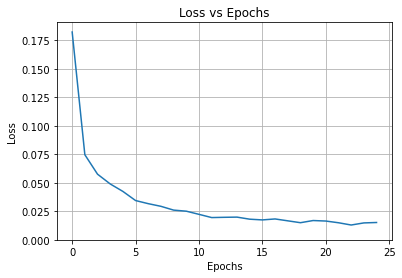

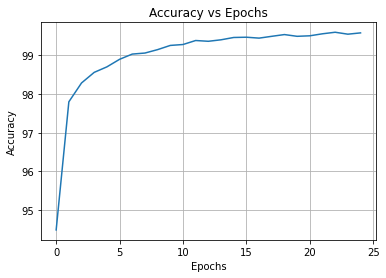

In [32]:
visualize_loss_accuracy(epochloss,epochAccuracy)

In [33]:
test(model18,device,test_dataloader)


Test set: Average loss: 0.0294, Accuracy: 9932/10000 (99%)



### Observation in question -8

We observes that Accuracy is increasing for us with the use of xaviers initiallization
In the Xavier Initialization, the weights are initialized with keeping in mind that variance of the activations are the same across every layer, this actually help in dealing with exploding and vanishing gradients. The maths behind this can be seen below. Xaviers initialization is usually used with Tanh and sigmoid activation functions.

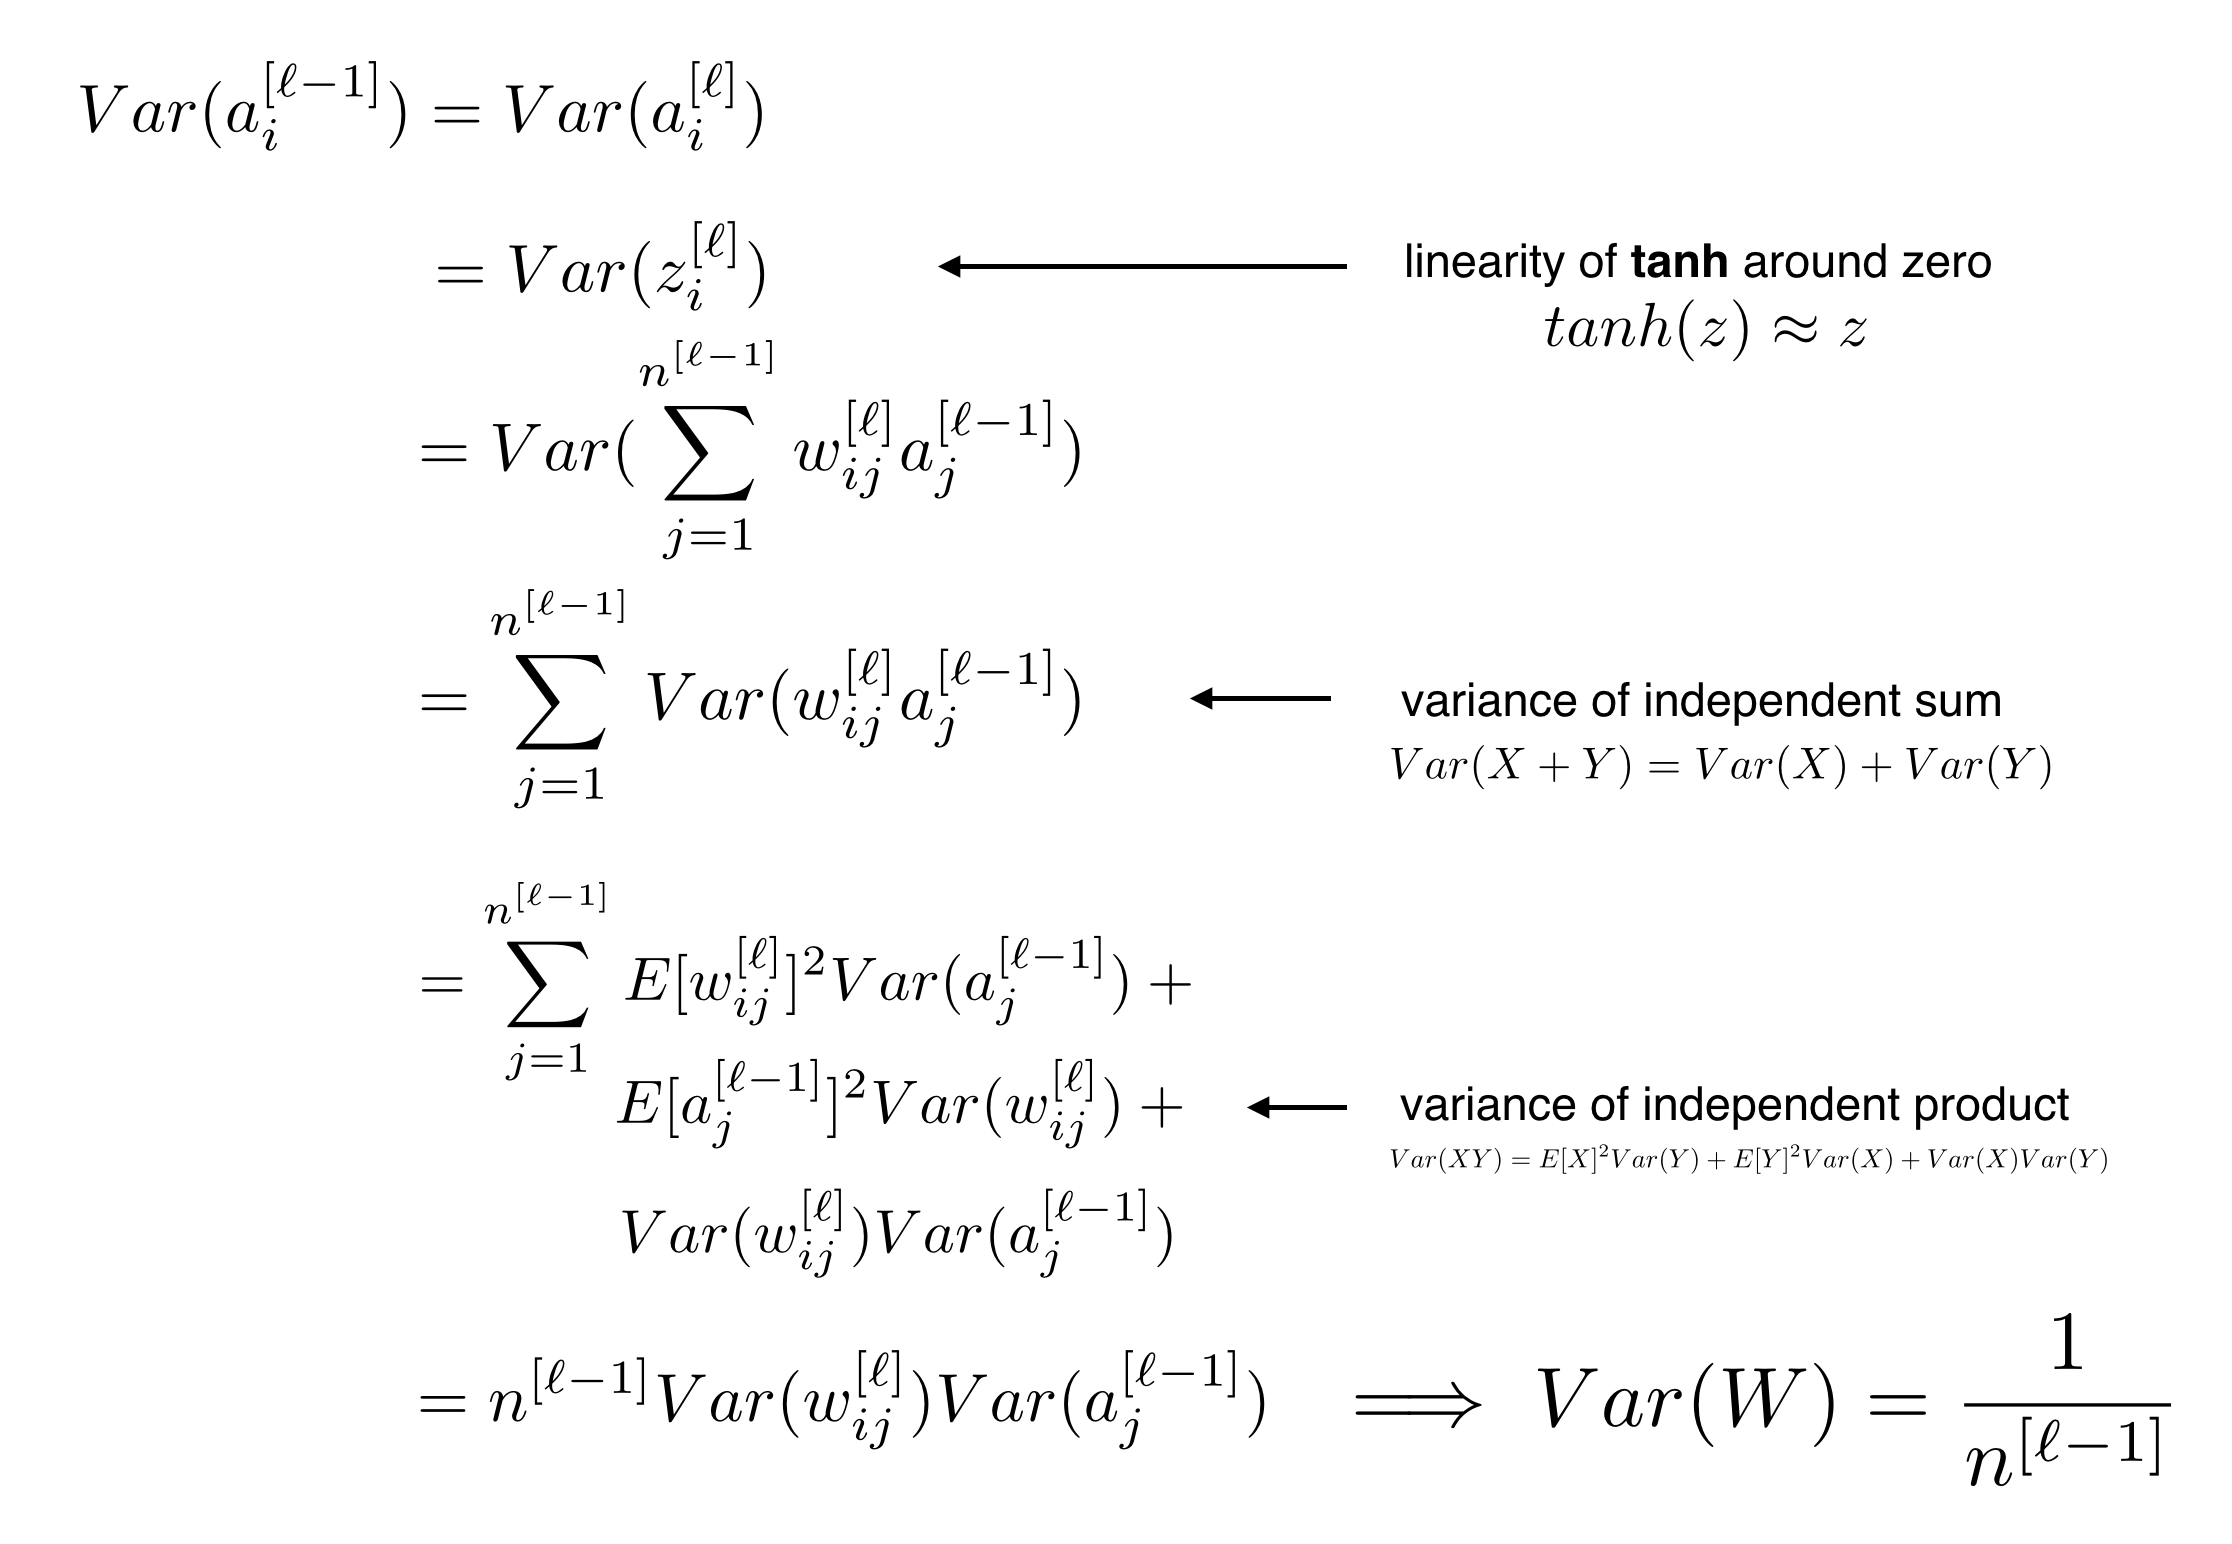

# Question 9

Add three batch-norm layers to the network defined in `Question-1` and report the final test accuracy. How does batch-norm help? 

In [34]:
class Net_BN(nn.Module):
    def __init__(self):
        super(Net_BN, self).__init__()
        #### YOUR CODE STARTS HERE ####
        
        # define a conv layer with output channels as 16, kernel size of 3 and stride of 1
        
        self.conv1 = nn.Conv2d(in_channels = 1,out_channels = 16,kernel_size=3,stride = 1)
        self.bn1= nn.BatchNorm2d(16)
        
        # define a conv layer with output channels as 32, kernel size of 3 and stride of 1
        
        self.conv2 = nn.Conv2d(in_channels = 16,out_channels = 32,kernel_size=3,stride = 1)
        self.bn2 = nn.BatchNorm2d(32)
        
        # define a conv layer with output channels as 64, kernel size of 3 and stride of 1
        
        self.conv3 = nn.Conv2d(in_channels = 32,out_channels = 64,kernel_size=3,stride = 1)
        self.bn3 = nn.BatchNorm2d(64)
        
        # define a max pooling layer with kernel size 2
        self.m1 = nn.MaxPool2d(kernel_size=2,stride = 2)
        
        # define dropout layer with a probability of 0.25
        self.d1 = nn.Dropout(p=0.25)
        
        # define dropout layer with a probability of 0.5
        self.d2 = nn.Dropout(p=0.5)
        
        # define a linear(dense) layer with 128 output features
        self.fc1 = nn.Linear(in_features=64*11*11,out_features=128)
        
        # define a linear(dense) layer with output features corresponding to the number of classes in the dataset
        self.fc2 = nn.Linear(in_features=128,out_features=10)
        
        #### YOUR CODE ENDS HERE ####

    def forward(self, x):

        #### YOUR CODE STARTS HERE ####
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.m1(x)
        x = x.view(-1,64*11*11)
        x = self.d1(x)
        x = F.relu(self.fc1(x))
        x = self.d2(x)
        out = self.fc2(x)
        
        #### YOUR CODE ENDS HERE ####
        output = F.log_softmax(out, dim=1)
        return output



In [35]:
%%time
model_BN = Net_BN().to(device)
optimizer = optim.Adam(model_BN.parameters(),lr=0.001)

epochloss = []
epochAccuracy = []
epochs = 25
for epoch in range(1,epochs+1):
    loss,accuracy = train(model_BN,device,train_dataloader,optimizer,epoch)
    epochloss.append(loss)
    epochAccuracy.append(accuracy)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.419616
Train Epoch: 1 [640/60000 (1%)]	Loss: 1.111607
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.145115
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.712726
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.701560
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.223596
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.262800
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.299990
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.452962
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.542403
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.237670
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.336549
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.592369
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.242764
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.154844
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.401038
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.627221
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.176527
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.400098
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.503811
Train Epoch: 1 [12800/60000 (

Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.307325
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.090596
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.154943
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.141017
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.069328
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.052047
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.153344
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.043317
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.637304
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.093479
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.312392
Train Epoch: 2 [53120/60000 (89%)]	Loss: 0.199405
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.027689
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.133734
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.148467
Train Epoch: 2 [55680/60000 (93%)]	Loss: 0.021281
Train Epoch: 2 [56320/60000 (94%)]	Loss: 0.025461
Train Epoch: 2 [56960/60000 (95%)]	Loss: 0.055013
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.298382
Train Epoch: 2 [58240/60000 (97%)]	Loss: 0.197401


Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.115864
Train Epoch: 4 [32640/60000 (54%)]	Loss: 0.058275
Train Epoch: 4 [33280/60000 (55%)]	Loss: 0.217668
Train Epoch: 4 [33920/60000 (57%)]	Loss: 0.039186
Train Epoch: 4 [34560/60000 (58%)]	Loss: 0.039731
Train Epoch: 4 [35200/60000 (59%)]	Loss: 0.067050
Train Epoch: 4 [35840/60000 (60%)]	Loss: 0.069524
Train Epoch: 4 [36480/60000 (61%)]	Loss: 0.119610
Train Epoch: 4 [37120/60000 (62%)]	Loss: 0.442056
Train Epoch: 4 [37760/60000 (63%)]	Loss: 0.098857
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.041062
Train Epoch: 4 [39040/60000 (65%)]	Loss: 0.249599
Train Epoch: 4 [39680/60000 (66%)]	Loss: 0.034725
Train Epoch: 4 [40320/60000 (67%)]	Loss: 0.126223
Train Epoch: 4 [40960/60000 (68%)]	Loss: 0.065709
Train Epoch: 4 [41600/60000 (69%)]	Loss: 0.102819
Train Epoch: 4 [42240/60000 (70%)]	Loss: 0.029554
Train Epoch: 4 [42880/60000 (71%)]	Loss: 0.046145
Train Epoch: 4 [43520/60000 (73%)]	Loss: 0.024708
Train Epoch: 4 [44160/60000 (74%)]	Loss: 0.025322


Train Epoch: 6 [17920/60000 (30%)]	Loss: 0.164157
Train Epoch: 6 [18560/60000 (31%)]	Loss: 0.079409
Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.085815
Train Epoch: 6 [19840/60000 (33%)]	Loss: 0.059833
Train Epoch: 6 [20480/60000 (34%)]	Loss: 0.028260
Train Epoch: 6 [21120/60000 (35%)]	Loss: 0.059836
Train Epoch: 6 [21760/60000 (36%)]	Loss: 0.063979
Train Epoch: 6 [22400/60000 (37%)]	Loss: 0.102295
Train Epoch: 6 [23040/60000 (38%)]	Loss: 0.032210
Train Epoch: 6 [23680/60000 (39%)]	Loss: 0.114971
Train Epoch: 6 [24320/60000 (41%)]	Loss: 0.273175
Train Epoch: 6 [24960/60000 (42%)]	Loss: 0.020001
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.107249
Train Epoch: 6 [26240/60000 (44%)]	Loss: 0.007306
Train Epoch: 6 [26880/60000 (45%)]	Loss: 0.132315
Train Epoch: 6 [27520/60000 (46%)]	Loss: 0.055649
Train Epoch: 6 [28160/60000 (47%)]	Loss: 0.174036
Train Epoch: 6 [28800/60000 (48%)]	Loss: 0.138452
Train Epoch: 6 [29440/60000 (49%)]	Loss: 0.121069
Train Epoch: 6 [30080/60000 (50%)]	Loss: 0.112028


Train Epoch: 8 [3200/60000 (5%)]	Loss: 0.156745
Train Epoch: 8 [3840/60000 (6%)]	Loss: 0.084117
Train Epoch: 8 [4480/60000 (7%)]	Loss: 0.120588
Train Epoch: 8 [5120/60000 (9%)]	Loss: 0.074531
Train Epoch: 8 [5760/60000 (10%)]	Loss: 0.010388
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.016263
Train Epoch: 8 [7040/60000 (12%)]	Loss: 0.008162
Train Epoch: 8 [7680/60000 (13%)]	Loss: 0.003350
Train Epoch: 8 [8320/60000 (14%)]	Loss: 0.048576
Train Epoch: 8 [8960/60000 (15%)]	Loss: 0.035681
Train Epoch: 8 [9600/60000 (16%)]	Loss: 0.016683
Train Epoch: 8 [10240/60000 (17%)]	Loss: 0.210979
Train Epoch: 8 [10880/60000 (18%)]	Loss: 0.000339
Train Epoch: 8 [11520/60000 (19%)]	Loss: 0.012335
Train Epoch: 8 [12160/60000 (20%)]	Loss: 0.061984
Train Epoch: 8 [12800/60000 (21%)]	Loss: 0.052900
Train Epoch: 8 [13440/60000 (22%)]	Loss: 0.001299
Train Epoch: 8 [14080/60000 (23%)]	Loss: 0.005367
Train Epoch: 8 [14720/60000 (25%)]	Loss: 0.399421
Train Epoch: 8 [15360/60000 (26%)]	Loss: 0.068124
Train Epoch: 8 

Train Epoch: 9 [48640/60000 (81%)]	Loss: 0.010124
Train Epoch: 9 [49280/60000 (82%)]	Loss: 0.002621
Train Epoch: 9 [49920/60000 (83%)]	Loss: 0.110872
Train Epoch: 9 [50560/60000 (84%)]	Loss: 0.047893
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.001759
Train Epoch: 9 [51840/60000 (86%)]	Loss: 0.082771
Train Epoch: 9 [52480/60000 (87%)]	Loss: 0.151221
Train Epoch: 9 [53120/60000 (89%)]	Loss: 0.062880
Train Epoch: 9 [53760/60000 (90%)]	Loss: 0.043123
Train Epoch: 9 [54400/60000 (91%)]	Loss: 0.013096
Train Epoch: 9 [55040/60000 (92%)]	Loss: 0.010458
Train Epoch: 9 [55680/60000 (93%)]	Loss: 0.081029
Train Epoch: 9 [56320/60000 (94%)]	Loss: 0.028497
Train Epoch: 9 [56960/60000 (95%)]	Loss: 0.021467
Train Epoch: 9 [57600/60000 (96%)]	Loss: 0.191359
Train Epoch: 9 [58240/60000 (97%)]	Loss: 0.076678
Train Epoch: 9 [58880/60000 (98%)]	Loss: 0.022268
Train Epoch: 9 [59520/60000 (99%)]	Loss: 0.072922
Train Epoch: 10 [0/60000 (0%)]	Loss: 0.038685
Train Epoch: 10 [640/60000 (1%)]	Loss: 0.017165
Train 

Train Epoch: 11 [32640/60000 (54%)]	Loss: 0.081337
Train Epoch: 11 [33280/60000 (55%)]	Loss: 0.041297
Train Epoch: 11 [33920/60000 (57%)]	Loss: 0.037992
Train Epoch: 11 [34560/60000 (58%)]	Loss: 0.022773
Train Epoch: 11 [35200/60000 (59%)]	Loss: 0.504421
Train Epoch: 11 [35840/60000 (60%)]	Loss: 0.094284
Train Epoch: 11 [36480/60000 (61%)]	Loss: 0.072149
Train Epoch: 11 [37120/60000 (62%)]	Loss: 0.036480
Train Epoch: 11 [37760/60000 (63%)]	Loss: 0.008335
Train Epoch: 11 [38400/60000 (64%)]	Loss: 0.007761
Train Epoch: 11 [39040/60000 (65%)]	Loss: 0.035293
Train Epoch: 11 [39680/60000 (66%)]	Loss: 0.006248
Train Epoch: 11 [40320/60000 (67%)]	Loss: 0.075951
Train Epoch: 11 [40960/60000 (68%)]	Loss: 0.010185
Train Epoch: 11 [41600/60000 (69%)]	Loss: 0.035293
Train Epoch: 11 [42240/60000 (70%)]	Loss: 0.134556
Train Epoch: 11 [42880/60000 (71%)]	Loss: 0.014566
Train Epoch: 11 [43520/60000 (73%)]	Loss: 0.060269
Train Epoch: 11 [44160/60000 (74%)]	Loss: 0.002499
Train Epoch: 11 [44800/60000 (7

Train Epoch: 13 [16000/60000 (27%)]	Loss: 0.034045
Train Epoch: 13 [16640/60000 (28%)]	Loss: 0.001140
Train Epoch: 13 [17280/60000 (29%)]	Loss: 0.065166
Train Epoch: 13 [17920/60000 (30%)]	Loss: 0.058509
Train Epoch: 13 [18560/60000 (31%)]	Loss: 0.012567
Train Epoch: 13 [19200/60000 (32%)]	Loss: 0.122170
Train Epoch: 13 [19840/60000 (33%)]	Loss: 0.046503
Train Epoch: 13 [20480/60000 (34%)]	Loss: 0.001141
Train Epoch: 13 [21120/60000 (35%)]	Loss: 0.169692
Train Epoch: 13 [21760/60000 (36%)]	Loss: 0.041930
Train Epoch: 13 [22400/60000 (37%)]	Loss: 0.043402
Train Epoch: 13 [23040/60000 (38%)]	Loss: 0.038724
Train Epoch: 13 [23680/60000 (39%)]	Loss: 0.024525
Train Epoch: 13 [24320/60000 (41%)]	Loss: 0.024235
Train Epoch: 13 [24960/60000 (42%)]	Loss: 0.006837
Train Epoch: 13 [25600/60000 (43%)]	Loss: 0.012178
Train Epoch: 13 [26240/60000 (44%)]	Loss: 0.012734
Train Epoch: 13 [26880/60000 (45%)]	Loss: 0.002493
Train Epoch: 13 [27520/60000 (46%)]	Loss: 0.048299
Train Epoch: 13 [28160/60000 (4

Train Epoch: 14 [59520/60000 (99%)]	Loss: 0.003692
Train Epoch: 15 [0/60000 (0%)]	Loss: 0.091320
Train Epoch: 15 [640/60000 (1%)]	Loss: 0.002106
Train Epoch: 15 [1280/60000 (2%)]	Loss: 0.002744
Train Epoch: 15 [1920/60000 (3%)]	Loss: 0.001926
Train Epoch: 15 [2560/60000 (4%)]	Loss: 0.003347
Train Epoch: 15 [3200/60000 (5%)]	Loss: 0.015001
Train Epoch: 15 [3840/60000 (6%)]	Loss: 0.035051
Train Epoch: 15 [4480/60000 (7%)]	Loss: 0.000017
Train Epoch: 15 [5120/60000 (9%)]	Loss: 0.003508
Train Epoch: 15 [5760/60000 (10%)]	Loss: 0.063305
Train Epoch: 15 [6400/60000 (11%)]	Loss: 0.061133
Train Epoch: 15 [7040/60000 (12%)]	Loss: 0.002040
Train Epoch: 15 [7680/60000 (13%)]	Loss: 0.018502
Train Epoch: 15 [8320/60000 (14%)]	Loss: 0.003089
Train Epoch: 15 [8960/60000 (15%)]	Loss: 0.117977
Train Epoch: 15 [9600/60000 (16%)]	Loss: 0.034650
Train Epoch: 15 [10240/60000 (17%)]	Loss: 0.004110
Train Epoch: 15 [10880/60000 (18%)]	Loss: 0.000680
Train Epoch: 15 [11520/60000 (19%)]	Loss: 0.082991
Train Epo

Train Epoch: 16 [42880/60000 (71%)]	Loss: 0.151581
Train Epoch: 16 [43520/60000 (73%)]	Loss: 0.055098
Train Epoch: 16 [44160/60000 (74%)]	Loss: 0.035843
Train Epoch: 16 [44800/60000 (75%)]	Loss: 0.056060
Train Epoch: 16 [45440/60000 (76%)]	Loss: 0.004881
Train Epoch: 16 [46080/60000 (77%)]	Loss: 0.008310
Train Epoch: 16 [46720/60000 (78%)]	Loss: 0.081920
Train Epoch: 16 [47360/60000 (79%)]	Loss: 0.002445
Train Epoch: 16 [48000/60000 (80%)]	Loss: 0.034946
Train Epoch: 16 [48640/60000 (81%)]	Loss: 0.022183
Train Epoch: 16 [49280/60000 (82%)]	Loss: 0.036091
Train Epoch: 16 [49920/60000 (83%)]	Loss: 0.001618
Train Epoch: 16 [50560/60000 (84%)]	Loss: 0.005689
Train Epoch: 16 [51200/60000 (85%)]	Loss: 0.014473
Train Epoch: 16 [51840/60000 (86%)]	Loss: 0.009573
Train Epoch: 16 [52480/60000 (87%)]	Loss: 0.006264
Train Epoch: 16 [53120/60000 (89%)]	Loss: 0.019091
Train Epoch: 16 [53760/60000 (90%)]	Loss: 0.042868
Train Epoch: 16 [54400/60000 (91%)]	Loss: 0.000254
Train Epoch: 16 [55040/60000 (9

KeyboardInterrupt: 

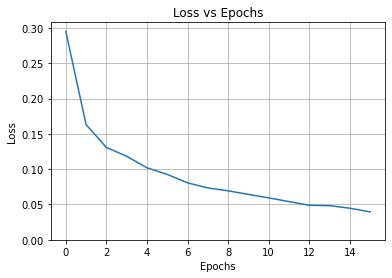

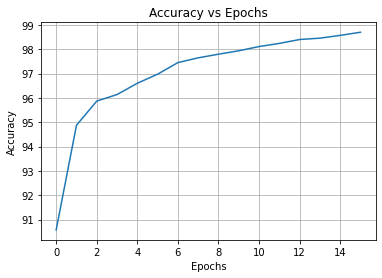

In [36]:
visualize_loss_accuracy(epochloss,epochAccuracy)

In [37]:
test(model_BN,device,test_dataloader)


Test set: Average loss: 0.0287, Accuracy: 9933/10000 (99%)



### Observation

###### with batch normalization + ReLU we are getting best accuracy of all the above models. 

* generally we have covariance shift problem where test and training data have different distributions. 
* Also we do training with mini batches and the distribution of different batches can be entirely different known as internal covariate shift. To handel this we use batch normalisation. 
* Batch normalization also regulerizes our model, reducing need of other regulerization techniques such as dropout
* Model with Batchnorm converge faster as mean is shifted to zero and variance is reduced to unit value.

# Part-3 (Optional)

This section is un-graded and purely for practice. 

Main focus of this part is to help you flex the deep learning muscles built in the above part. You should build a network on the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This dataset is similar to MNIST but unlike MNIST, the images are colored and more complex. 

As of writing this, the state-of-the-art(SoTA) performance on this dataset is 98.98%. You can try to start with the simple network we defined above for the MNSIT dataset(with some modification for dealing with different sized colored images unlike MNIST). But to achive the SoTA performance you need to do a lot of hackery. These are list of few things, we would encourage you to try: 

- Use data augmentation wisely. Read and understand how to perform the augmentations listed below. 
    * RandomFlips, Color Jittering
    * Cutout, Cutmix
    * Mixup
    * Auto-augment

- Try to increase the image size using standard image interpolation techniques. Try using tricks like Progressive resizing of images and see if it helps. 

- After certain number of layers, adding more layer might not be of much help, run experiments on SVHN and see if you observe this. 

- To understand the difficulties in training deeper networks read this paper: [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)

- To improve the performance on SVHN, try using architectures like [ResNet](https://arxiv.org/abs/1512.03385), [DesnseNet](https://arxiv.org/abs/1608.06993) or [EfficientNet](https://arxiv.org/abs/1905.11946). Most of these architectures are available by default in PyTorch.
